AGU23 analysis of crater + premix submarine

In [5]:
# Require python>=3.9

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Config
import copy
import os
import numpy as np
from numpy.linalg import norm
import matplotlib
import matplotlib.pyplot as plt

# Path for ffmpeg (if animations are needed)
plt.rcParams['animation.ffmpeg_path'] = "C:\\Users\\Fredric\\Documents\\ffmpeg\\ffmpeg-n4.4-latest-win64-gpl-4.4\\bin\\ffmpeg.exe"

# Path for .pkl files output
# target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\tungurahua\\"
target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\submarine\\"
# target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\results_dx4m\\"

# Path for Quail source code
source_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\src\\"

# Path for Quail entry point
quail_path = os.path.join(source_dir, "quail")

In [8]:
# Import quail modules
os.chdir(source_dir)
import argparse
import importlib
import sys
import scipy

import defaultparams as default_deck
import errors
from general import ShapeType, SolverType, PhysicsType

import meshing.common as mesh_common
import meshing.gmsh as mesh_gmsh
import meshing.tools as mesh_tools

import numerics.helpers.helpers as helpers
import numerics.timestepping.tools as stepper_tools

import physics.zerodimensional.zerodimensional as zerod
import physics.euler.euler as euler
import physics.navierstokes.navierstokes as navierstokes
import physics.scalar.scalar as scalar
import physics.chemistry.chemistry as chemistry
import physics.multiphasevpT.multiphasevpT as multiphasevpT
import physics.multiphaseWLMA.multiphaseWLMA as multiphaseWLMA
import physics.multiphaseWLMA.iapws95_light.mixtureWLMA as mixtureWLMA

import processing.readwritedatafiles as readwritedatafiles
import processing.post as post
import processing.plot as plot
import processing
import processing.mdtools as mdtools

import solver.DG as DG
import solver.ADERDG as ADERDG
import solver.tools as solver_tools

import time
import multiprocessing as mp
from multidomain import Domain, Observer

from types import SimpleNamespace

os.chdir(target_dir)

### Data prep

In [9]:
# Default physics backend construction
wlma = mixtureWLMA.WLMA()

In [37]:
# <BOOKMARK> <1>
# file_name_i = lambda i: f"deep_submarine_premix1_atm1_{i}.pkl"
# file_name_i = lambda i: f"H:\\submarine\\crater8\\deep_submarine_crater8_atm1_{i}.pkl"
# file_name_i = lambda i: f"H:\\submarine\\crater7\\deep_submarine_crater7_atm1_{i}.pkl"
# file_name_i = lambda i: f"H:\\submarine\\crater6\\deep_submarine_crater6_atm1_{i}.pkl"

# Blast series
file_name_i = lambda i: f"deep_submarine_crater5_atm1_{i}.pkl"                                 # 0.95
# file_name_i = lambda i: f"deep_submarine_crater10blast_atm1_{i}.pkl"   # 0.75
file_name_i = lambda i: f"H:\\submarine\\crater9\\deep_submarine_crater9blast_atm1_{i}.pkl"    # 0.50

solver_from = lambda i: readwritedatafiles.read_data_file(file_name_i(i))
solver_from_multi = lambda domidx, i: readwritedatafiles.read_data_file(file_name_i(i))
# Initial condition state
physics0 = solver_from_multi(1,0).physics
x, _ = mdtools.downsample(solver_from_multi(1,0))
U_ess = physics0.IC.get_state(physics0, x, 0.0)

In [13]:
''' Data ingestion routine '''

def process_file(time_idx, domain_read_list, solver_read_callback) -> SimpleNamespace:
  cat_x = []
  cat_rho_mix = []
  cat_ya = []
  cat_yw = []
  cat_ym = []
  cat_u = []
  cat_v = []
  cat_steamfrac = []
  cat_rhow = []
  cat_p = []
  cat_T = []
  cat_psat = []
  cat_E = []
  cat_c = []
  cat_alphaw = []
  cat_aux = []

  for dom_idx in domain_read_list:
    solver = solver_read_callback(dom_idx, time_idx)

    t = solver.time
    # JANK: manually reconstruct the downsampled conservative variables
    x, _U0 = mdtools.downsample(solver, "pDensityA")
    _, _U1 = mdtools.downsample(solver, "pDensityWv")
    _, _U2 = mdtools.downsample(solver, "pDensityM")
    _, _U3 = mdtools.downsample(solver, "XMomentum")
    _, _U4 = mdtools.downsample(solver, "YMomentum")
    _, _U5 = mdtools.downsample(solver, "Energy")

    rhow, p, T, c, alphaw = wlma.WLM_rhopT_native(
      np.concatenate((_U0, _U1, _U2), axis=-1),
      np.concatenate((_U3, _U4), axis=-1), _U5)
    # Compute saturation properties for each point in the downsample
    tuplize = lambda sat_obj: (sat_obj["psat"],
                              sat_obj["rho_satl"],
                              sat_obj["rho_satv"])
    # Compute saturation information as a list of tuples for each point
    sat_info = [tuplize(mixtureWLMA.float_mix_functions.prho_sat(_T))
                for _T in T.ravel()]
    # Define map to steam fraction
    fn_steamfrac = lambda rhow, sat_tup: np.clip(
    (1.0/rhow - 1.0/sat_tup[1]) / (1.0/sat_tup[2] - 1.0/sat_tup[1]), 0, 1.0
    )
    # Allocate psats, streamfrac
    psats = np.empty_like(rhow)
    steamfrac = np.empty_like(rhow)
    # Extract saturation pressures
    psats_tup, _, _ = zip(*sat_info)
    # Fill np arrays
    psats.ravel()[:] = np.array(psats_tup)
    steamfrac.ravel()[:] = list(map(fn_steamfrac, rhow.ravel(), sat_info))
    steamfrac = np.where(psats > 0, steamfrac, -1.0)

    rho_mix = _U0 + _U1 + _U2
    u = _U3 / rho_mix
    v = _U4 / rho_mix
    ya = _U0 / rho_mix
    yw = _U1 / rho_mix
    ym = _U2 / rho_mix

    # Wildcard quantity
    aux = np.empty_like(c)
    # Pure water sound speed
    aux.ravel()[:] = list(map(mixtureWLMA.float_mix_functions.sound_speed, rhow.ravel(), T.ravel()))

    cat_x.append(x)
    cat_rho_mix.append(rho_mix)
    cat_ya.append(ya)
    cat_yw.append(yw)
    cat_ym.append(ym)
    cat_u.append(u)
    cat_v.append(v)
    cat_steamfrac.append(steamfrac)
    cat_rhow.append(rhow)
    cat_p.append(p)
    cat_T.append(T)
    cat_psat.append(psats)
    cat_E.append(_U5)
    cat_c.append(c)
    cat_alphaw.append(alphaw)
    cat_aux.append(aux)

  # Global assembly
  x, rho_mix, ya, yw, ym, u, v, steamfrac, rhow, p, T, psats, U_E, c, alphaw, aux = [
    np.concatenate(cat_vec, axis=0) for cat_vec in (
      cat_x, cat_rho_mix, cat_ya, cat_yw, cat_ym,
      cat_u, cat_v, cat_steamfrac, cat_rhow, cat_p, cat_T, cat_psat, cat_E,
      cat_c, cat_alphaw, cat_aux
    )
  ]
  velnorm = np.sqrt(u*u + v*v)
  return SimpleNamespace(
    x=x,
    t=t,
    rho_mix=rho_mix,
    ya=ya,
    yw=yw,
    ym=ym,
    u=u,
    v=v,
    velnorm=velnorm,
    steamfrac=steamfrac,
    rhow=rhow,
    p=p,
    T=T,
    psats=psats,
    U_E=U_E,
    c=c,
    alphaw=alphaw,
    c_water=aux,
  )

### Generate plots

In [16]:
surf_height = 1000

hydrostatic_linear = lambda x: np.where(x < surf_height,
                                     -1000 * 9.8 * (x - surf_height) + 1e5,
                                     1e5)
p0_extrapolated = hydrostatic_linear(x[..., 1:2])


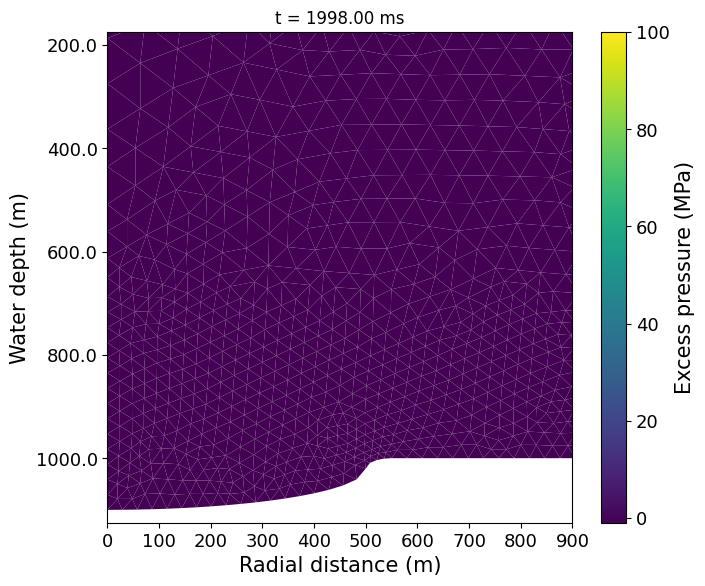

In [40]:
# Show pressure diff (bar) at several slices
plt.figure(figsize=(7.5,6.5), dpi=100)

clims = (-1, 100)

# TODO: np.arange(0,200,5) for crater5
for i in np.arange(0,1000,1): #np.arange(0,200,5):# np.arange(0,600+1,300): # to 200 (400 ms)
  plt.clf()
  soln_vars_i = process_file(i, [0], solver_from_multi)
  mdtools.plot_mean(x, (soln_vars_i.p - p0_extrapolated)/1e6, clims)
  # mdtools.plot_mean(x, soln_vars_i.T, clims)
  sm = plt.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
    cmap=plt.get_cmap())
  cb = plt.colorbar(sm)
  # tl = plt.title(f"Pressure delta (MPa) at t = {1e3*soln_vars_i.t:.2f} ms")
  tl = plt.title(f"t = {1e3*soln_vars_i.t:.2f} ms")

  # tl = plt.title(f"Pressure at t = {1e3*soln_vars_i.t:.2f} ms", fontsize=15)
  # tl = plt.title(f"Temperature at t = {1e3*soln_vars_i.t:.2f} ms", fontsize=15)
  # plt.xlim(0, 1000)
  # plt.ylim(-350, 650)
  plt.xlim(0,900)
  plt.ylim(-100,800)
  plt.xticks(fontsize=13)
  plt.yticks(fontsize=13)
  # cb.set_label(label='Temperature (K)', fontsize=15)
  cb.set_label(label='Excess pressure (MPa)', fontsize=15)

  plt.xlabel("Radial distance (m)", fontsize=15)
  ax = plt.gca()
  ax.yaxis.set_major_formatter(lambda x, _: f"{1000-x}")
  plt.ylabel("Water depth (m)", fontsize=15)
  cb.ax.tick_params(labelsize=13)

  out_file_name = f"dump_check_crater9blast_pressure_frame_{i}.png"
  plt.savefig(out_file_name, format="png")

In [198]:
file_name_i(0)

'H:\\submarine\\crater9\\deep_submarine_crater9blast_atm1_0.pkl'

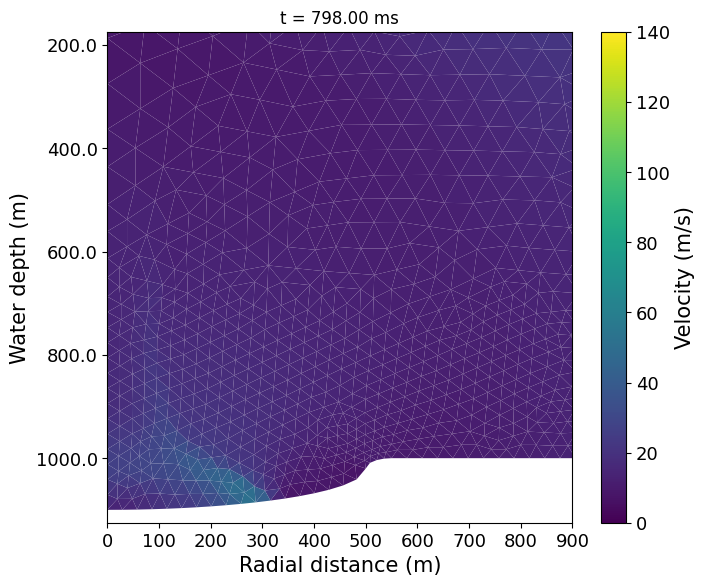

In [199]:
# Show pressure diff (bar) at several slices
plt.figure(figsize=(7.5,6.5), dpi=100)

clims = (0, 140)
# TODO: np.arange(0,200,5) for crater5
for i in np.arange(0,400,1): #np.arange(0,200,5):# np.arange(0,600+1,300): # to 200 (400 ms)
# for i in np.arange(0,1000,50): #np.arange(0,200,5):# np.arange(0,600+1,300): # to 200 (400 ms)
  plt.clf()
  soln_vars_i = process_file(i, [0], solver_from_multi)
  vel_norm = np.sqrt(soln_vars_i.u * soln_vars_i.u + soln_vars_i.v * soln_vars_i.v)
  mdtools.plot_mean(x, vel_norm, clims)
  # mdtools.plot_mean(x, (soln_vars_i.p - p0_extrapolated)/1e6, clims)
  # mdtools.plot_mean(x, soln_vars_i.T, clims)
  sm = plt.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
    cmap=plt.get_cmap())
  cb = plt.colorbar(sm)
  # tl = plt.title(f"Pressure delta (MPa) at t = {1e3*soln_vars_i.t:.2f} ms")
  tl = plt.title(f"t = {1e3*soln_vars_i.t:.2f} ms")

  # tl = plt.title(f"Pressure at t = {1e3*soln_vars_i.t:.2f} ms", fontsize=15)
  # tl = plt.title(f"Temperature at t = {1e3*soln_vars_i.t:.2f} ms", fontsize=15)
  # plt.xlim(0, 1000)
  # plt.ylim(-350, 650)
  plt.xlim(0,900)
  plt.ylim(-100,800)
  plt.xticks(fontsize=13)
  plt.yticks(fontsize=13)
  # cb.set_label(label='Temperature (K)', fontsize=15)
  cb.set_label(label='Velocity (m/s)', fontsize=15)

  plt.xlabel("Radial distance (m)", fontsize=15)
  ax = plt.gca()
  ax.yaxis.set_major_formatter(lambda x, _: f"{1000-x}")
  plt.ylabel("Water depth (m)", fontsize=15)
  cb.ax.tick_params(labelsize=13)

  out_file_name = f"redirect_frame_crater9blast_velocitynorm_frame_{i}.png"
  plt.savefig(out_file_name, format="png")

In [213]:
''' Movie compilation'''
# os.system("ffmpeg -r 10 -i crater9_png/check_crater9blast_pressure_frame_%01d.png -vcodec mpeg4 -y web_crater_blast_pressure_50-50.mp4")
# os.system("ffmpeg -r 10 -i frame_crater9blast_velocitynorm_frame_%01d.png -vcodec mpeg4 -y web_crater_blast_velocitynorm_50-50.mp4")
# os.system("ffmpeg -r 10 -i frames_crater9_temperature_frame_%01d.png -vcodec mpeg4 -y web_crater_blast_temperature_50-50.mp4")

os.system("ffmpeg -r 10 -i crater9_png/check_crater9blast_pressure_frame_%01d.png -vcodec mpeg4 -vb 40M -y webV40M_crater_blast_pressure_50-50.mp4")
os.system("ffmpeg -r 10 -i frame_crater9blast_velocitynorm_frame_%01d.png -vcodec mpeg4 -vb 40M -y webV40M_crater_blast_velocitynorm_50-50.mp4")
os.system("ffmpeg -r 10 -i frames_crater9_temperature_frame_%01d.png -vcodec mpeg4 -vb 40M -y webV40M_crater_blast_temperature_50-50.mp4")


0

In [ ]:
# GIF making from stackexchange

# from PIL import Image
# import glob

# # Create the frames
# frames = []
# imgs = glob.glob("crater9_png/check_crater9blast_pressure_frame_*.png")
# for i in imgs:
#     new_frame = Image.open(i)
#     frames.append(new_frame)

# # Save into a GIF file that loops forever
# frames[0].save('png_to_gif.gif', format='GIF',
#                append_images=frames[1:],
#                save_all=True,
#                duration=300, loop=0)

In [28]:
''' Borrow definition of control surface '''
class ControlSurface():
  def __init__(self, R, N):
    self.R = R
    self.N = N
    # Compute area of quarter-sphere
    self.A = np.pi * self.R * self.R
    # Evenly space nodes at circle center
    self.theta = np.linspace(0, 0.5*np.pi, 2*self.N+1)[1::2]
    self.dtheta = 0.5*np.pi / self.N
    # Compute Cartesian coordinates of sample points
    self.x = self.R * np.cos(self.theta)
    self.y = self.R * np.sin(self.theta)
    # Alias x coordinate as r (in cylindrical coordinates)
    self.r = self.x
    # Jacobian for quarter sphere is pi * R**2 sin(pi/2 - theta), where theta is the
    #   angle from the HORIZONTAL axis. jac_theta is the jacobian for integration
    #   against in-plane angle theta from the horizontal axis.
    self.jac_theta = np.pi * self.R * self.r
    # Define integration functional, contracting f_xy(r, y) along the first dimension
    # self.integrate = lambda f_xy: np.sum(
    #   f_xy(self.r, self.y)
    #   * (self.jac_theta * self.dtheta)[:,np.newaxis],
    #   # axis=(0,)
    #   axis=(0,1)
    # )
    self.integrate = lambda f_xy: np.einsum("j..., j -> ...",
      f_xy(self.r, self.y),
      self.jac_theta * self.dtheta,
    )

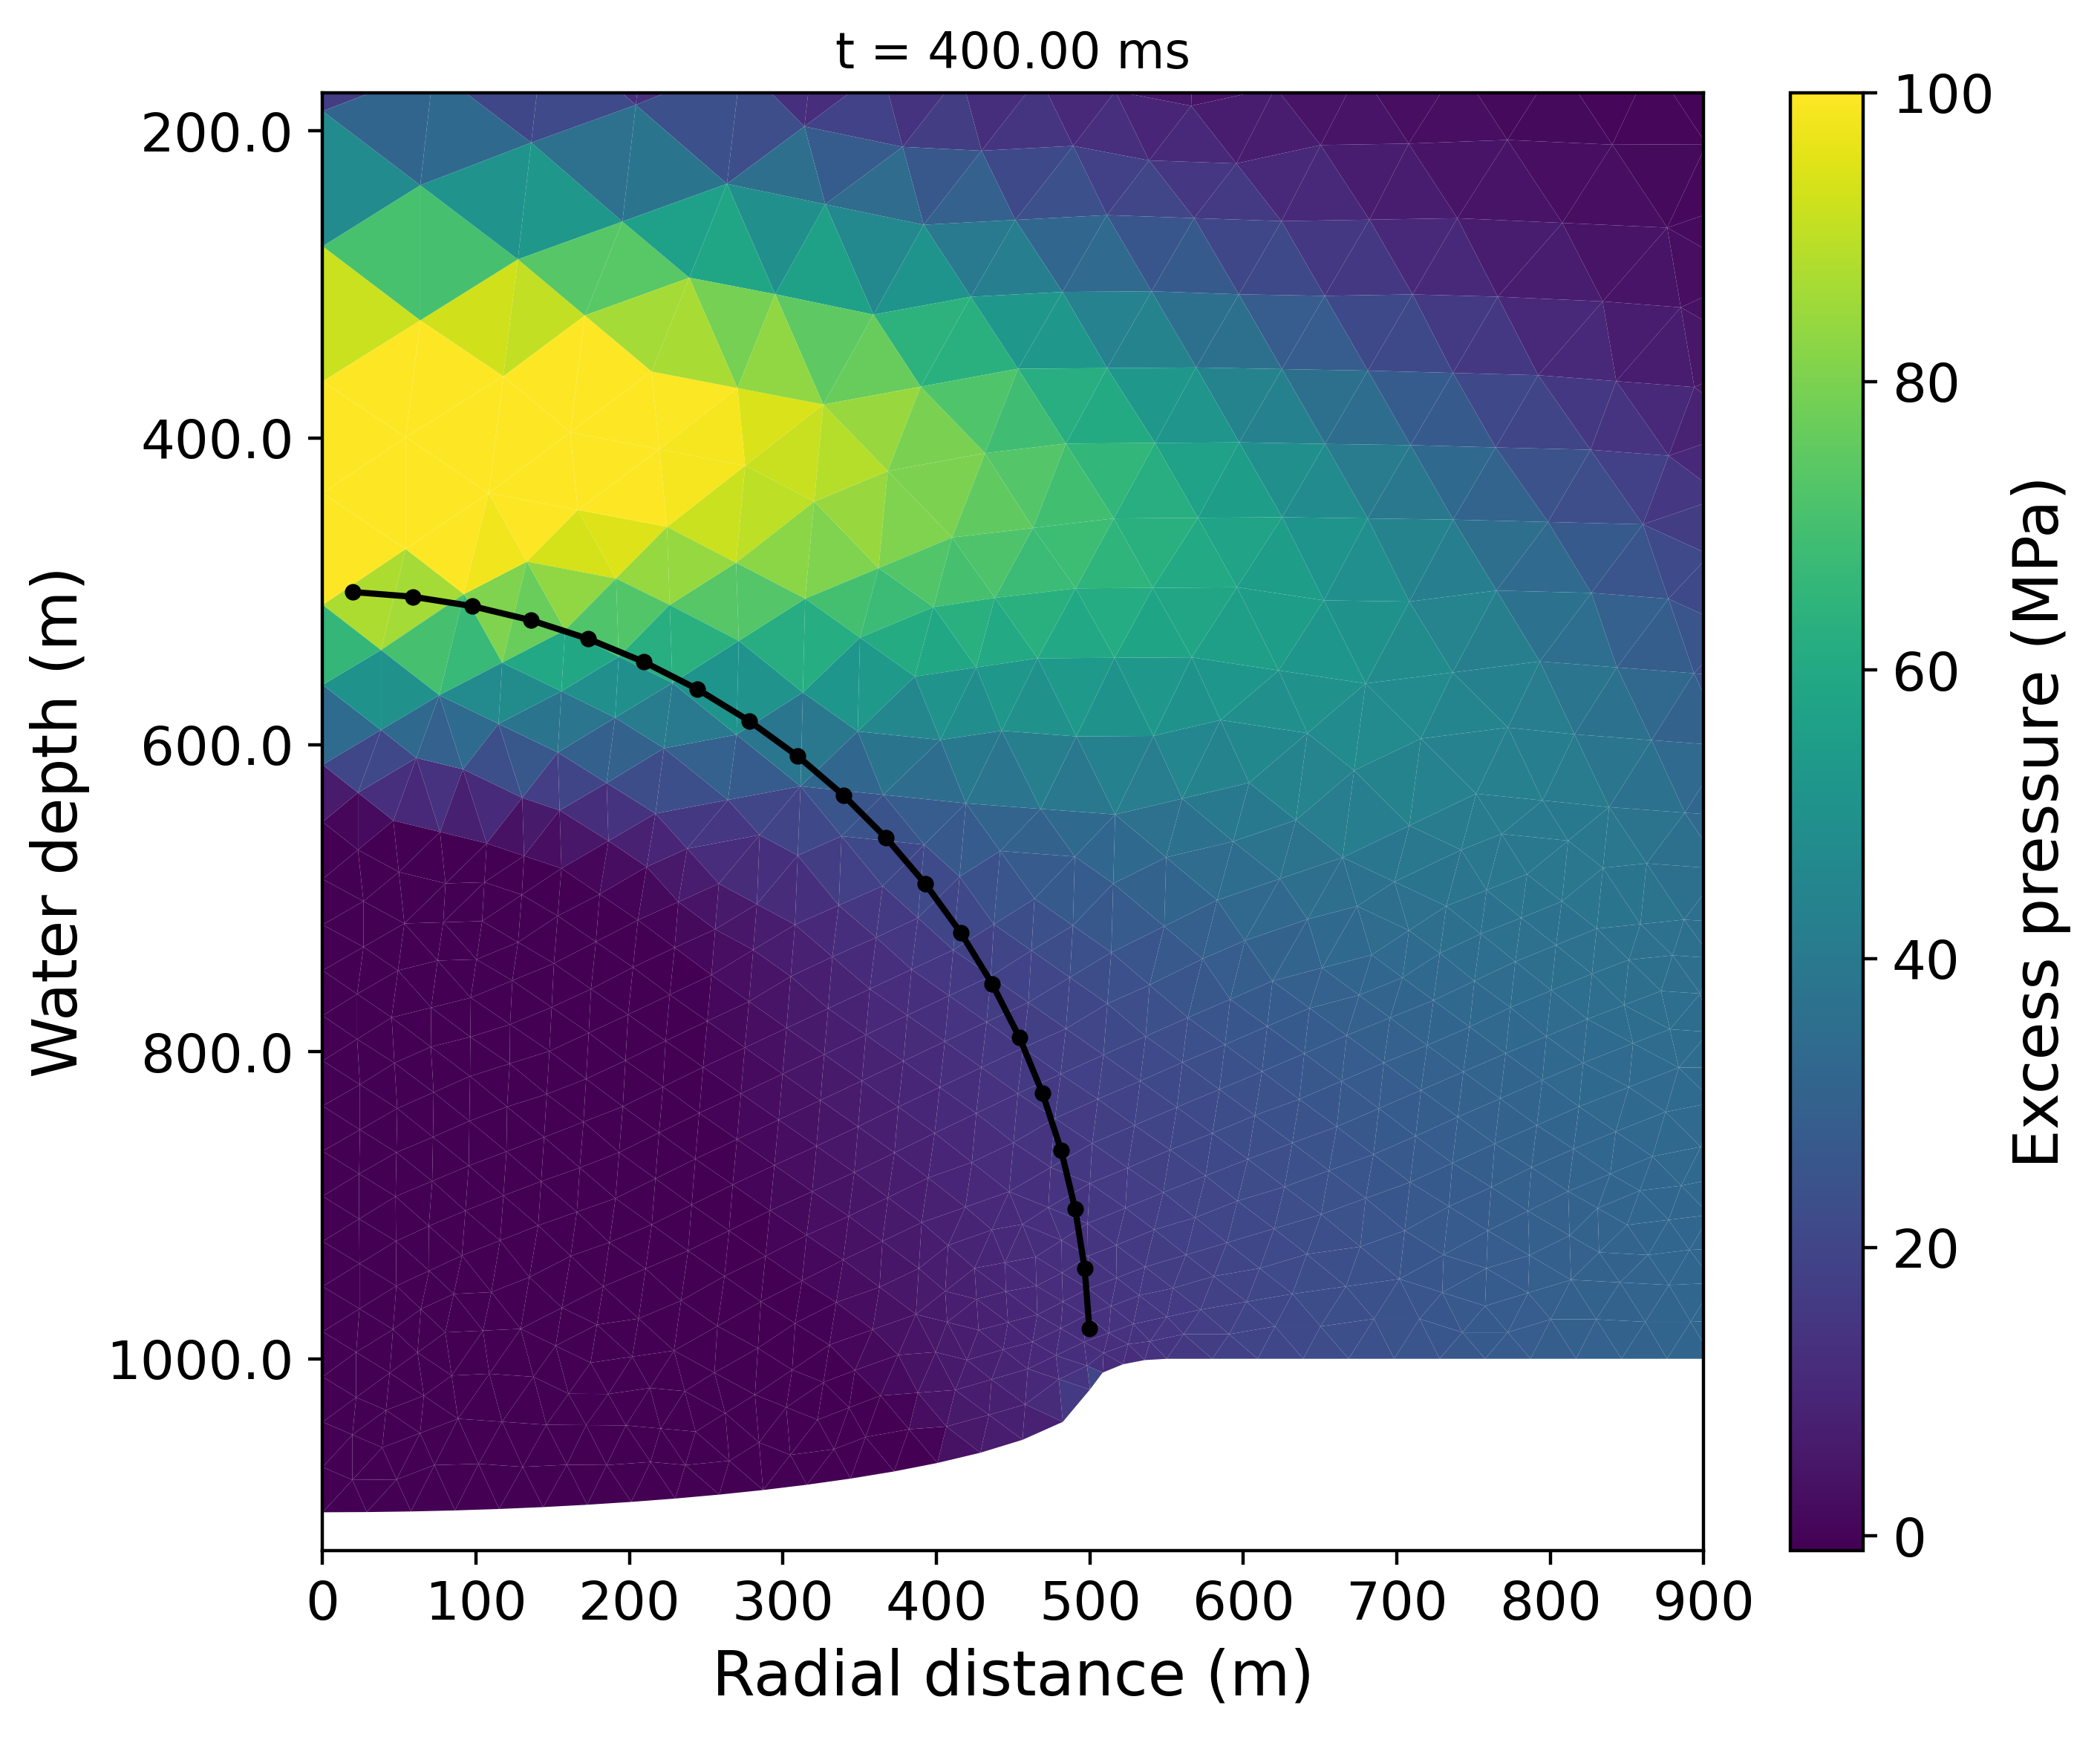

In [197]:
''' Generate plot showing control surface in tab10 palette '''
plt.figure(figsize=(7.5,6.5), dpi=400)
plt.clf()
clims = (-1, 100)
soln_vars_i = process_file(200, [0], solver_from_multi)
mdtools.plot_mean(x, (soln_vars_i.p - p0_extrapolated)/1e6, clims)
# mdtools.plot_mean(x, soln_vars_i.T, clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
# tl = plt.title(f"Pressure delta (MPa) at t = {1e3*soln_vars_i.t:.2f} ms")
tl = plt.title(f"t = {1e3*soln_vars_i.t:.2f} ms")

# tl = plt.title(f"Pressure at t = {1e3*soln_vars_i.t:.2f} ms", fontsize=15)
# tl = plt.title(f"Temperature at t = {1e3*soln_vars_i.t:.2f} ms", fontsize=15)
# plt.xlim(0, 1000)
# plt.ylim(-350, 650)
plt.xlim(0,900)
plt.ylim(-100,800)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# cb.set_label(label='Temperature (K)', fontsize=15)
cb.set_label(label='Excess pressure (MPa)', fontsize=15)

plt.xlabel("Radial distance (m)", fontsize=15)
ax = plt.gca()
ax.yaxis.set_major_formatter(lambda x, _: f"{1000-x}")
plt.ylabel("Water depth (m)", fontsize=15)
cb.ax.tick_params(labelsize=13)

plt.plot(ControlSurface(500,20).r, ControlSurface(500,20).y, '.-', color="#000000")
# plt.plot(ControlSurface(500,20).r, ControlSurface(500,20).y, '.-', color="#1f77b4")
# plt.plot(ControlSurface(750,20).r, ControlSurface(750,20).y, '.-', color="#ff7f0e")
# plt.plot(ControlSurface(1000,20).r, ControlSurface(1000,20).y, '.-', color="#2ca02c")

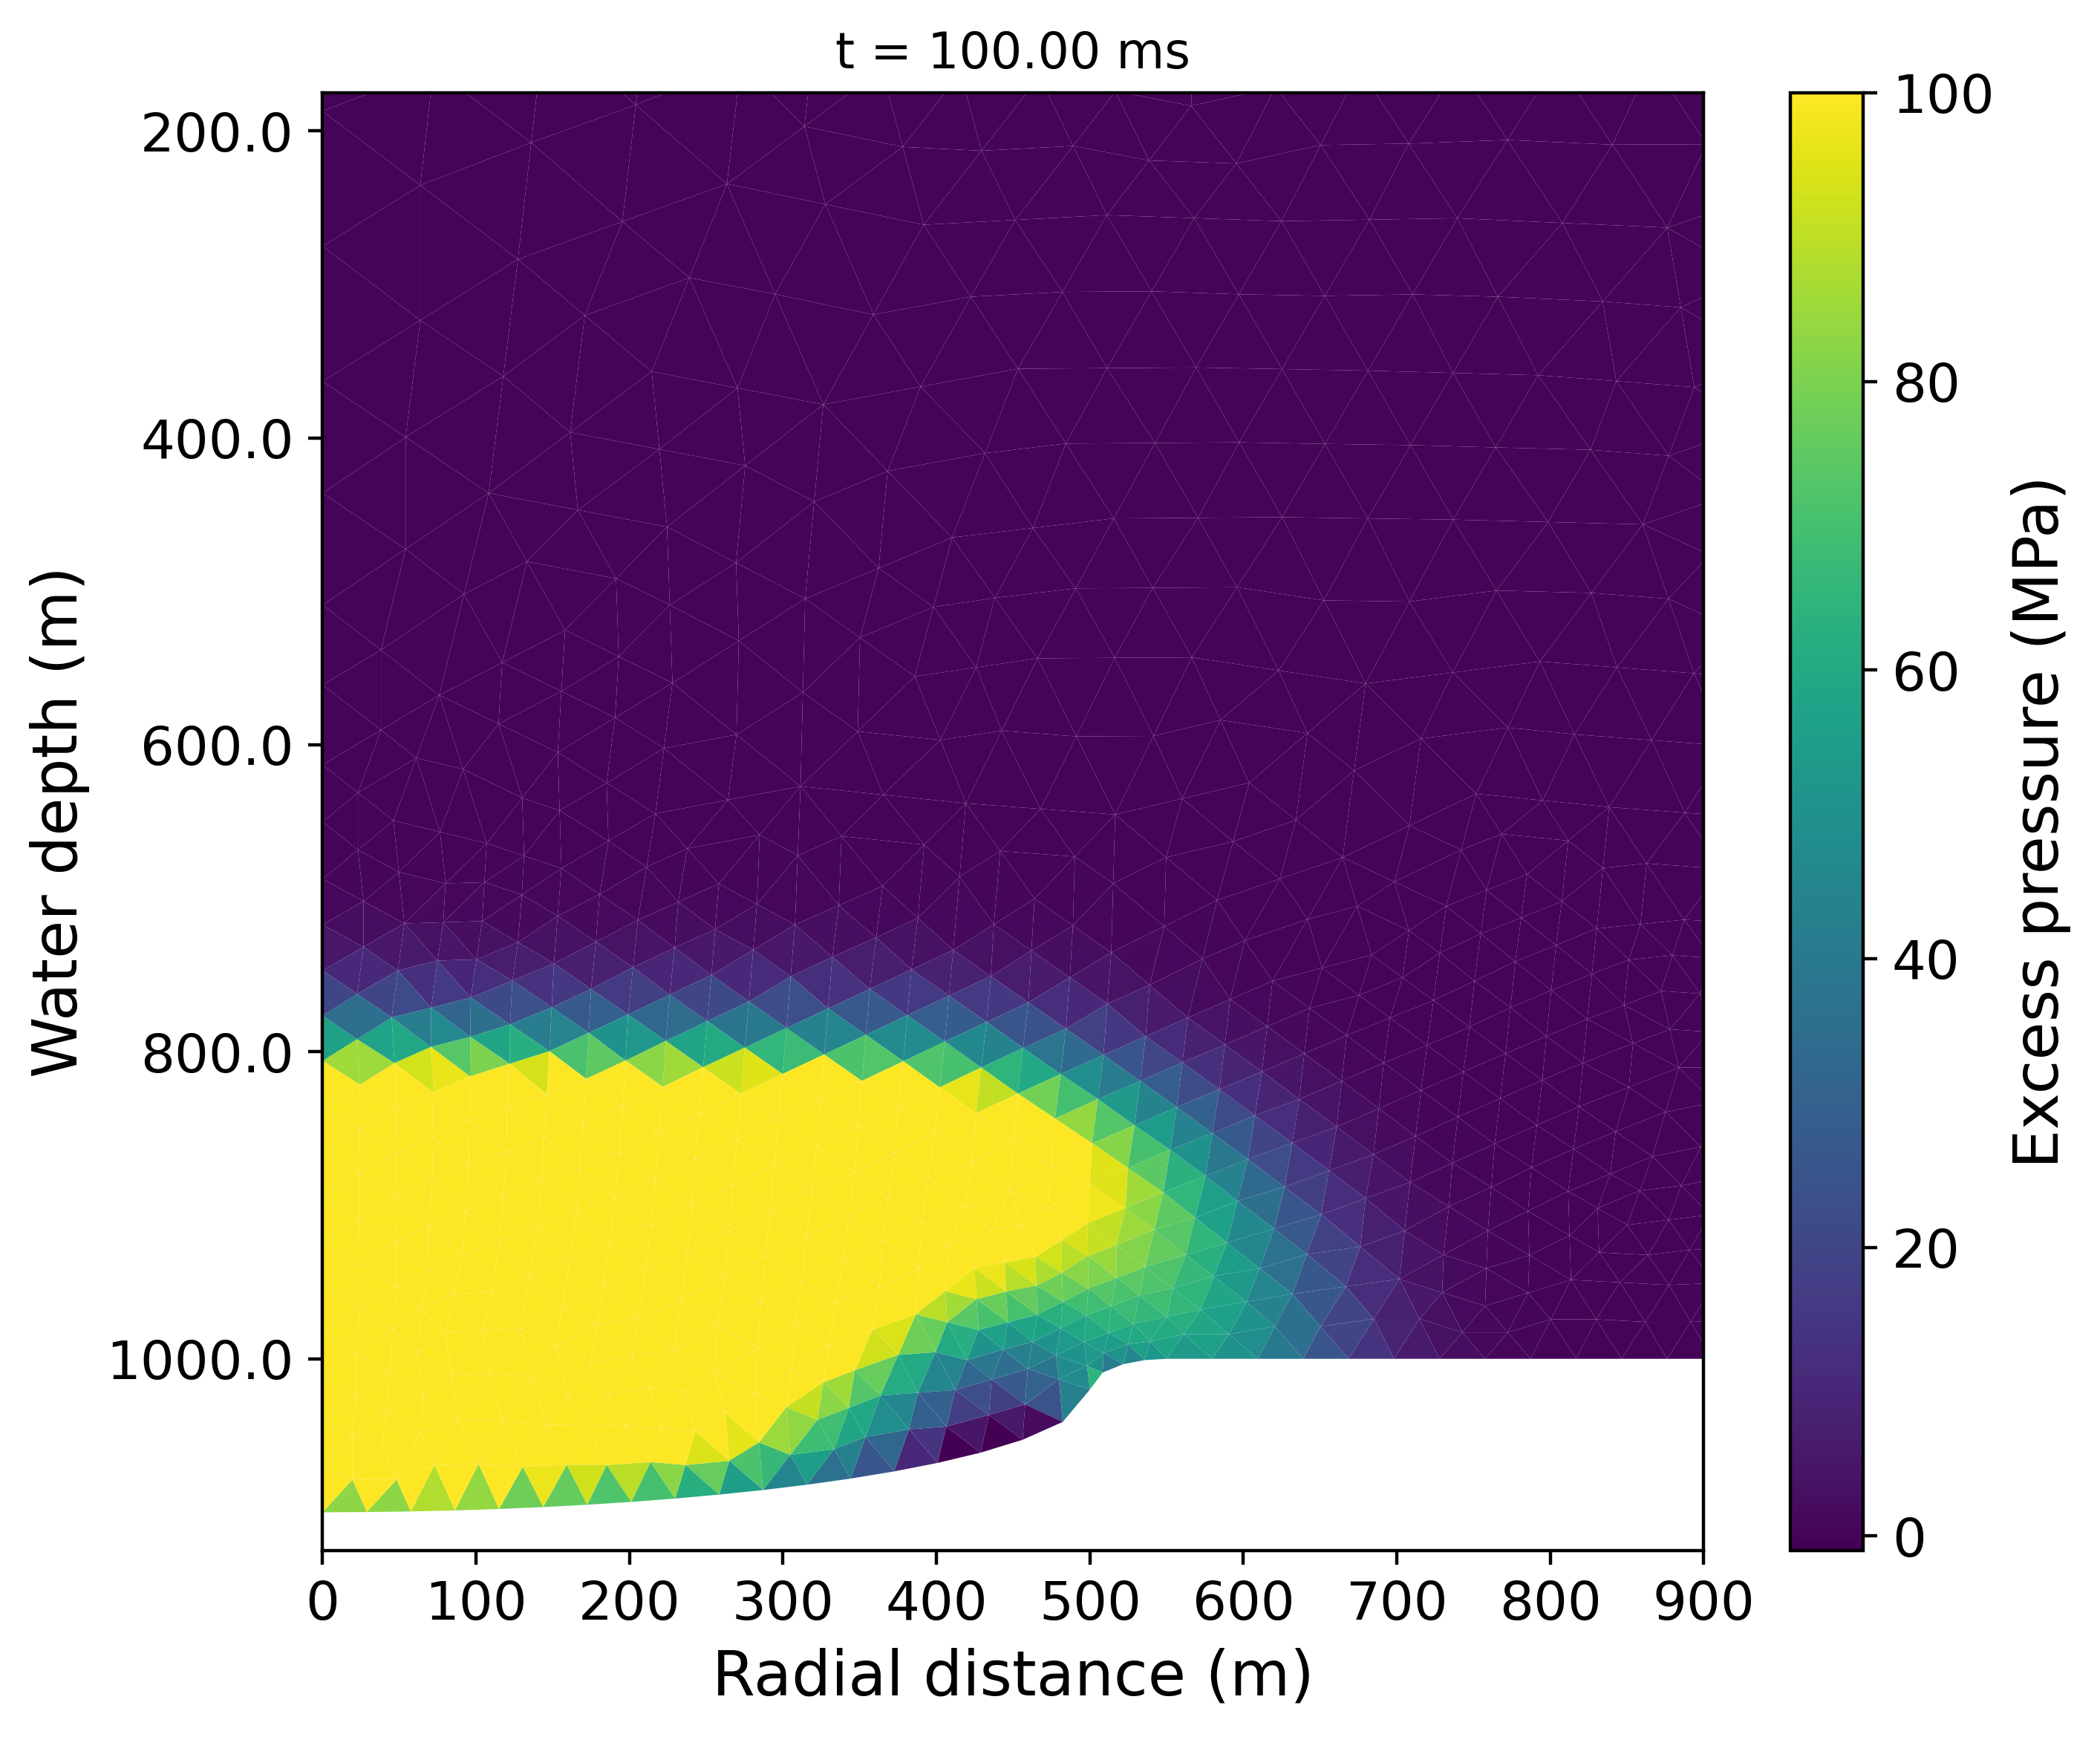

In [152]:
''' Generate plots for display '''
plt.figure(figsize=(7.5,6.5), dpi=400)
plt.clf()
clims = (-1, 100)
soln_vars_i = process_file(50, [0], solver_from_multi)
mdtools.plot_mean(x, (soln_vars_i.p - p0_extrapolated)/1e6, clims)
# mdtools.plot_mean(x, soln_vars_i.T, clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
# tl = plt.title(f"Pressure delta (MPa) at t = {1e3*soln_vars_i.t:.2f} ms")
tl = plt.title(f"t = {1e3*soln_vars_i.t:.2f} ms")

# tl = plt.title(f"Pressure at t = {1e3*soln_vars_i.t:.2f} ms", fontsize=15)
# tl = plt.title(f"Temperature at t = {1e3*soln_vars_i.t:.2f} ms", fontsize=15)
# plt.xlim(0, 1000)
# plt.ylim(-350, 650)
plt.xlim(0,900)
plt.ylim(-100,800)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# cb.set_label(label='Temperature (K)', fontsize=15)
cb.set_label(label='Excess pressure (MPa)', fontsize=15)

plt.xlabel("Radial distance (m)", fontsize=15)
ax = plt.gca()
ax.yaxis.set_major_formatter(lambda x, _: f"{1000-x}")
plt.ylabel("Water depth (m)", fontsize=15)
cb.ax.tick_params(labelsize=13)

# plt.plot(ControlSurface(500,20).r, ControlSurface(500,20).y, '.-', color="#1f77b4")
# plt.plot(ControlSurface(750,20).r, ControlSurface(750,20).y, '.-', color="#ff7f0e")
# plt.plot(ControlSurface(1000,20).r, ControlSurface(1000,20).y, '.-', color="#2ca02c")

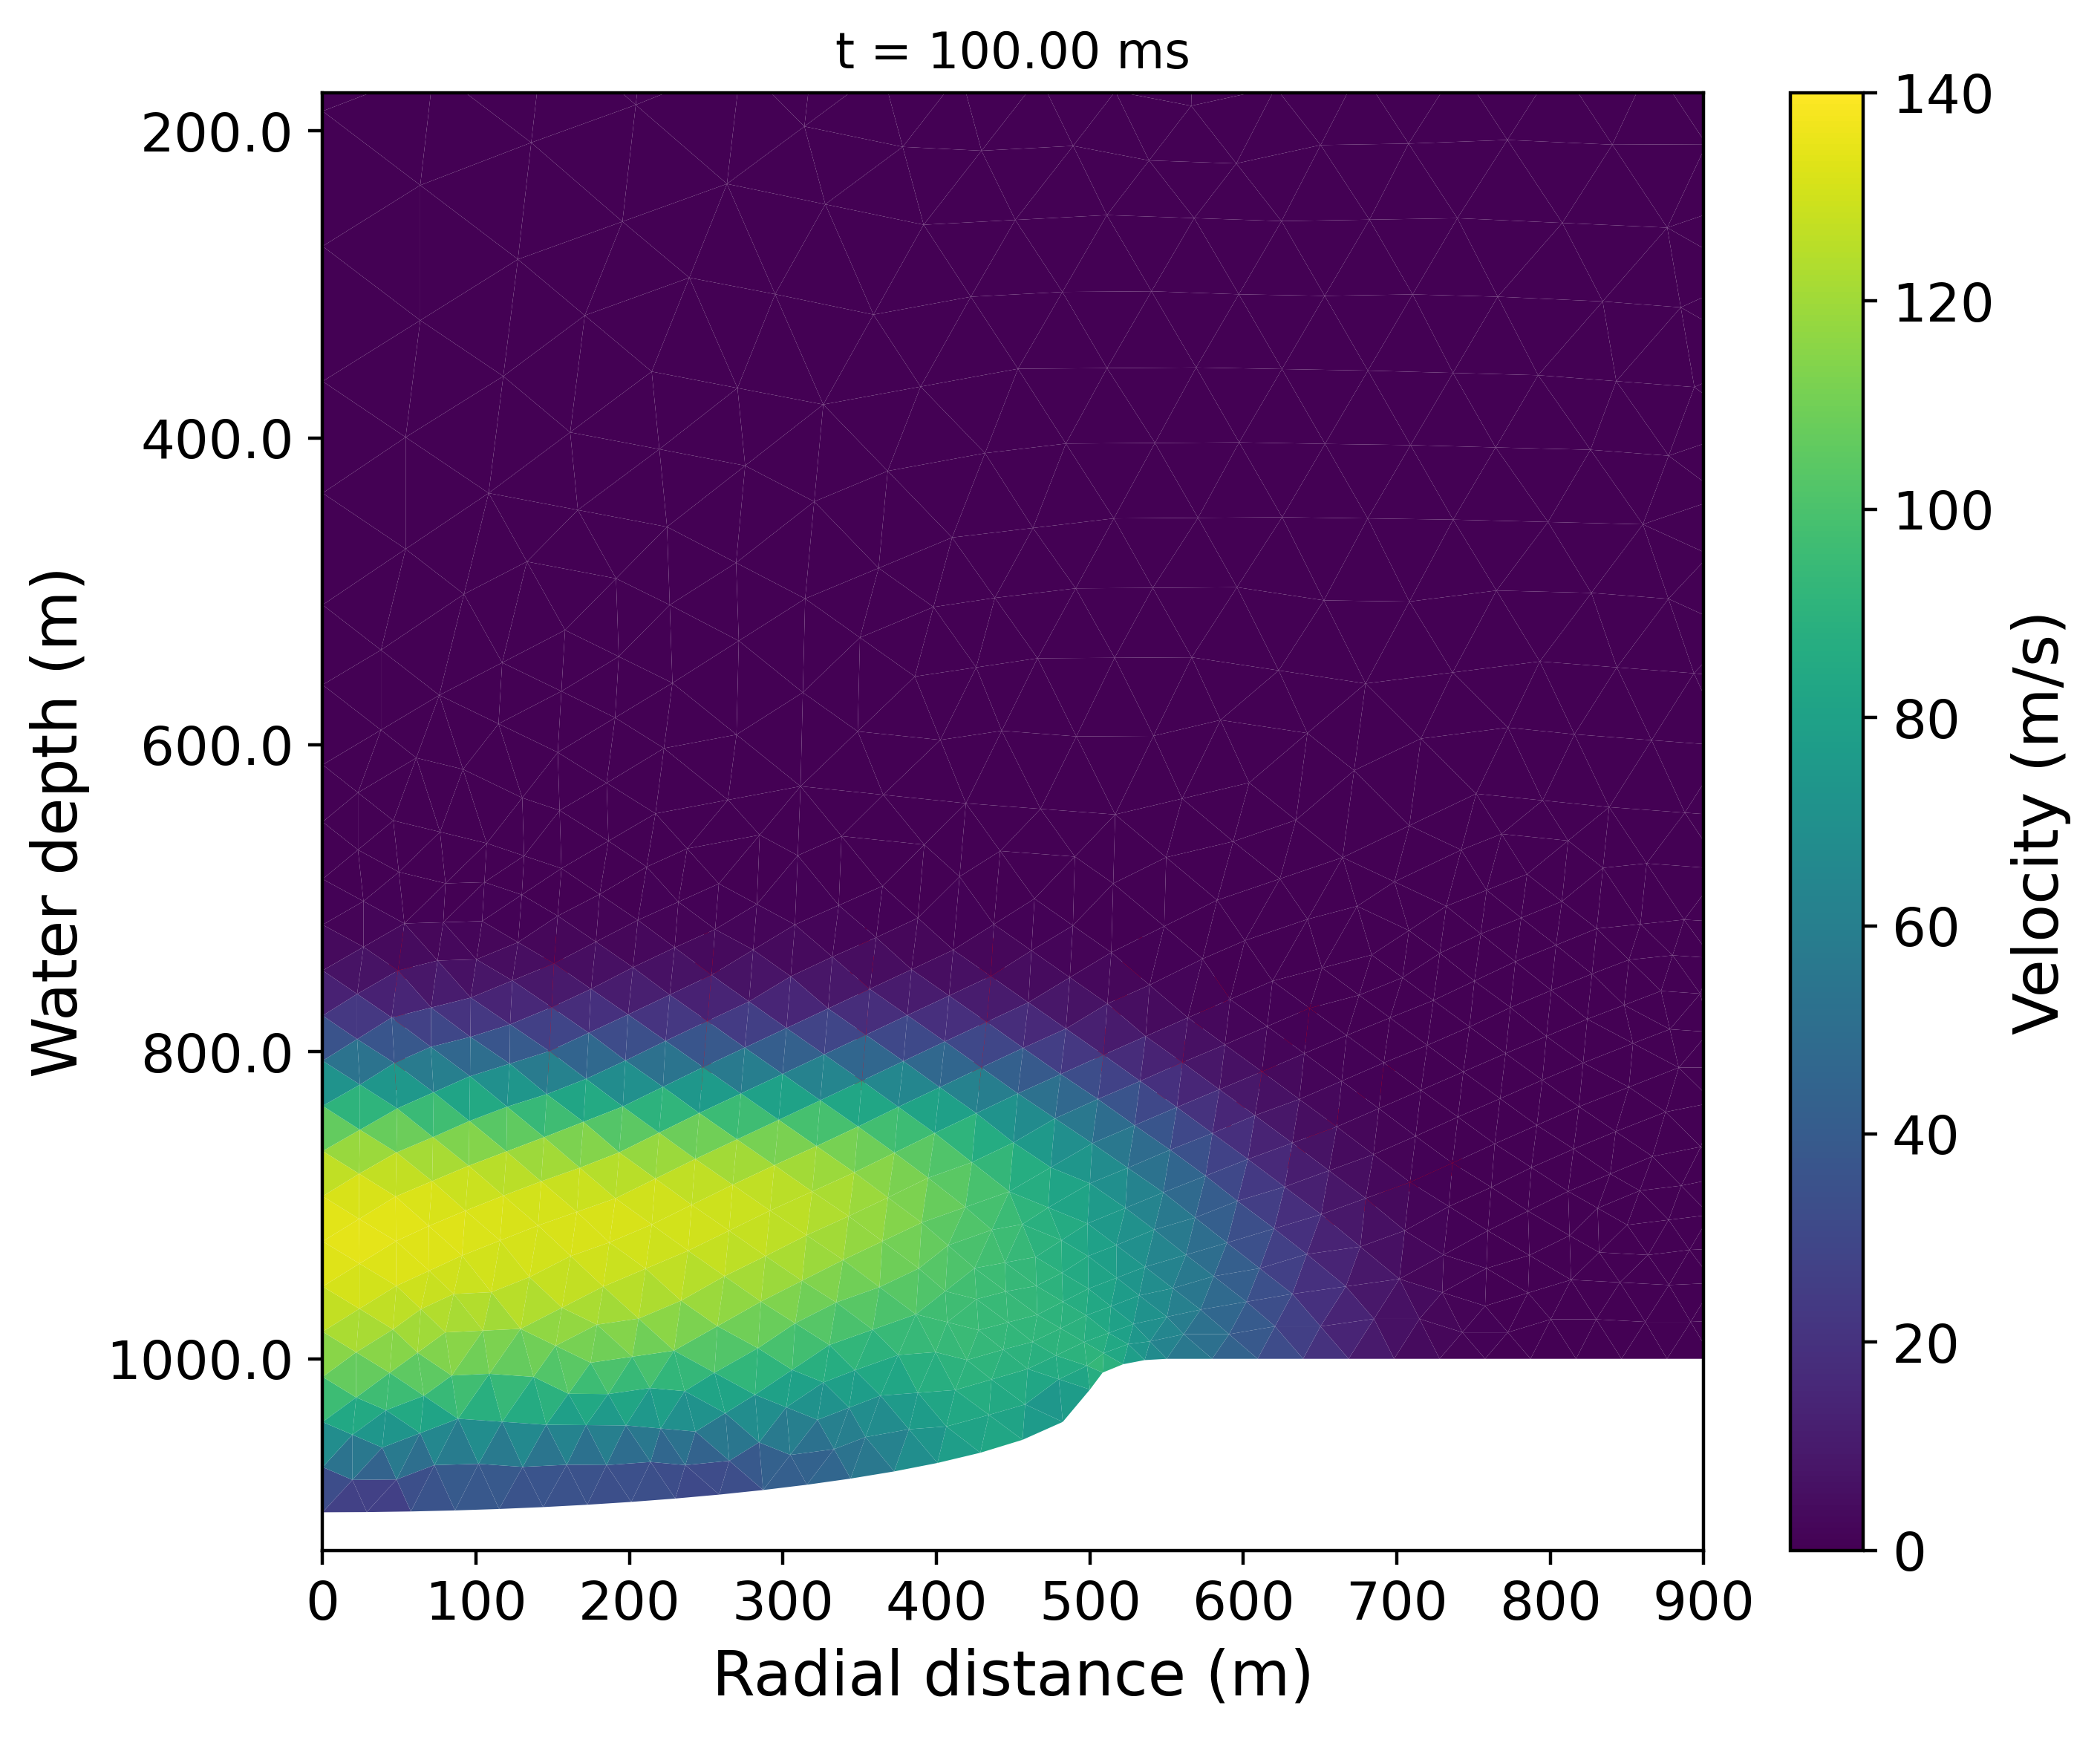

In [185]:
%matplotlib inline
''' Generate plots for display '''
plt.figure(figsize=(7.5,6.5), dpi=400)
plt.clf()
soln_vars_i = process_file(50, [0], solver_from_multi)
clims = (0, 140)
velocity_norm = np.sqrt(soln_vars_i.u * soln_vars_i.u + soln_vars_i.v * soln_vars_i.v)
mdtools.plot_mean(x, velocity_norm, clims)
# mdtools.plot_mean(x, soln_vars_i.T, clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
# tl = plt.title(f"Pressure delta (MPa) at t = {1e3*soln_vars_i.t:.2f} ms")
tl = plt.title(f"t = {1e3*soln_vars_i.t:.2f} ms")

# tl = plt.title(f"Pressure at t = {1e3*soln_vars_i.t:.2f} ms", fontsize=15)
# tl = plt.title(f"Temperature at t = {1e3*soln_vars_i.t:.2f} ms", fontsize=15)
# plt.xlim(0, 1000)
# plt.ylim(-350, 650)
plt.xlim(0,900)
plt.ylim(-100,800)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# cb.set_label(label='Temperature (K)', fontsize=15)
cb.set_label(label='Velocity (m/s)', fontsize=15)

plt.xlabel("Radial distance (m)", fontsize=15)
ax = plt.gca()
ax.yaxis.set_major_formatter(lambda x, _: f"{1000-x}")
plt.ylabel("Water depth (m)", fontsize=15)
cb.ax.tick_params(labelsize=13)

# Build circular arc
_theta_range = (np.pi / 2)* np.linspace(0, 1, 5+2)[-1:1:-1]
_arc_x, _arc_y = 500 + 175 * np.cos(_theta_range), 175 * np.sin(_theta_range)
# Indicate velocity direction
indicate_x = np.array([50,  150, 250, 350, 425, *_arc_x])
indicate_y = np.array([175, 175, 175, 175, 175, *_arc_y])
elem_indices = mdtools.SolverInterpolator(solver_from(0)).trifinder(indicate_x, indicate_y)
indicate_rhou = solver_from(50).state_coeffs[elem_indices, 0, 3:5]
indicate_n = indicate_rhou / np.linalg.norm(indicate_rhou, axis=-1, keepdims=True)
plt.quiver(indicate_x, indicate_y, indicate_n[...,0].ravel(), indicate_n[...,1].ravel(), 
           scale=1.8,
          scale_units="inches",
          #  units="dots",
          color="red",
           )

# plt.plot(ControlSurface(500,20).r, ControlSurface(500,20).y, '.-', color="#1f77b4")
# plt.plot(ControlSurface(750,20).r, ControlSurface(750,20).y, '.-', color="#ff7f0e")
# plt.plot(ControlSurface(1000,20).r, ControlSurface(1000,20).y, '.-', color="#2ca02c")

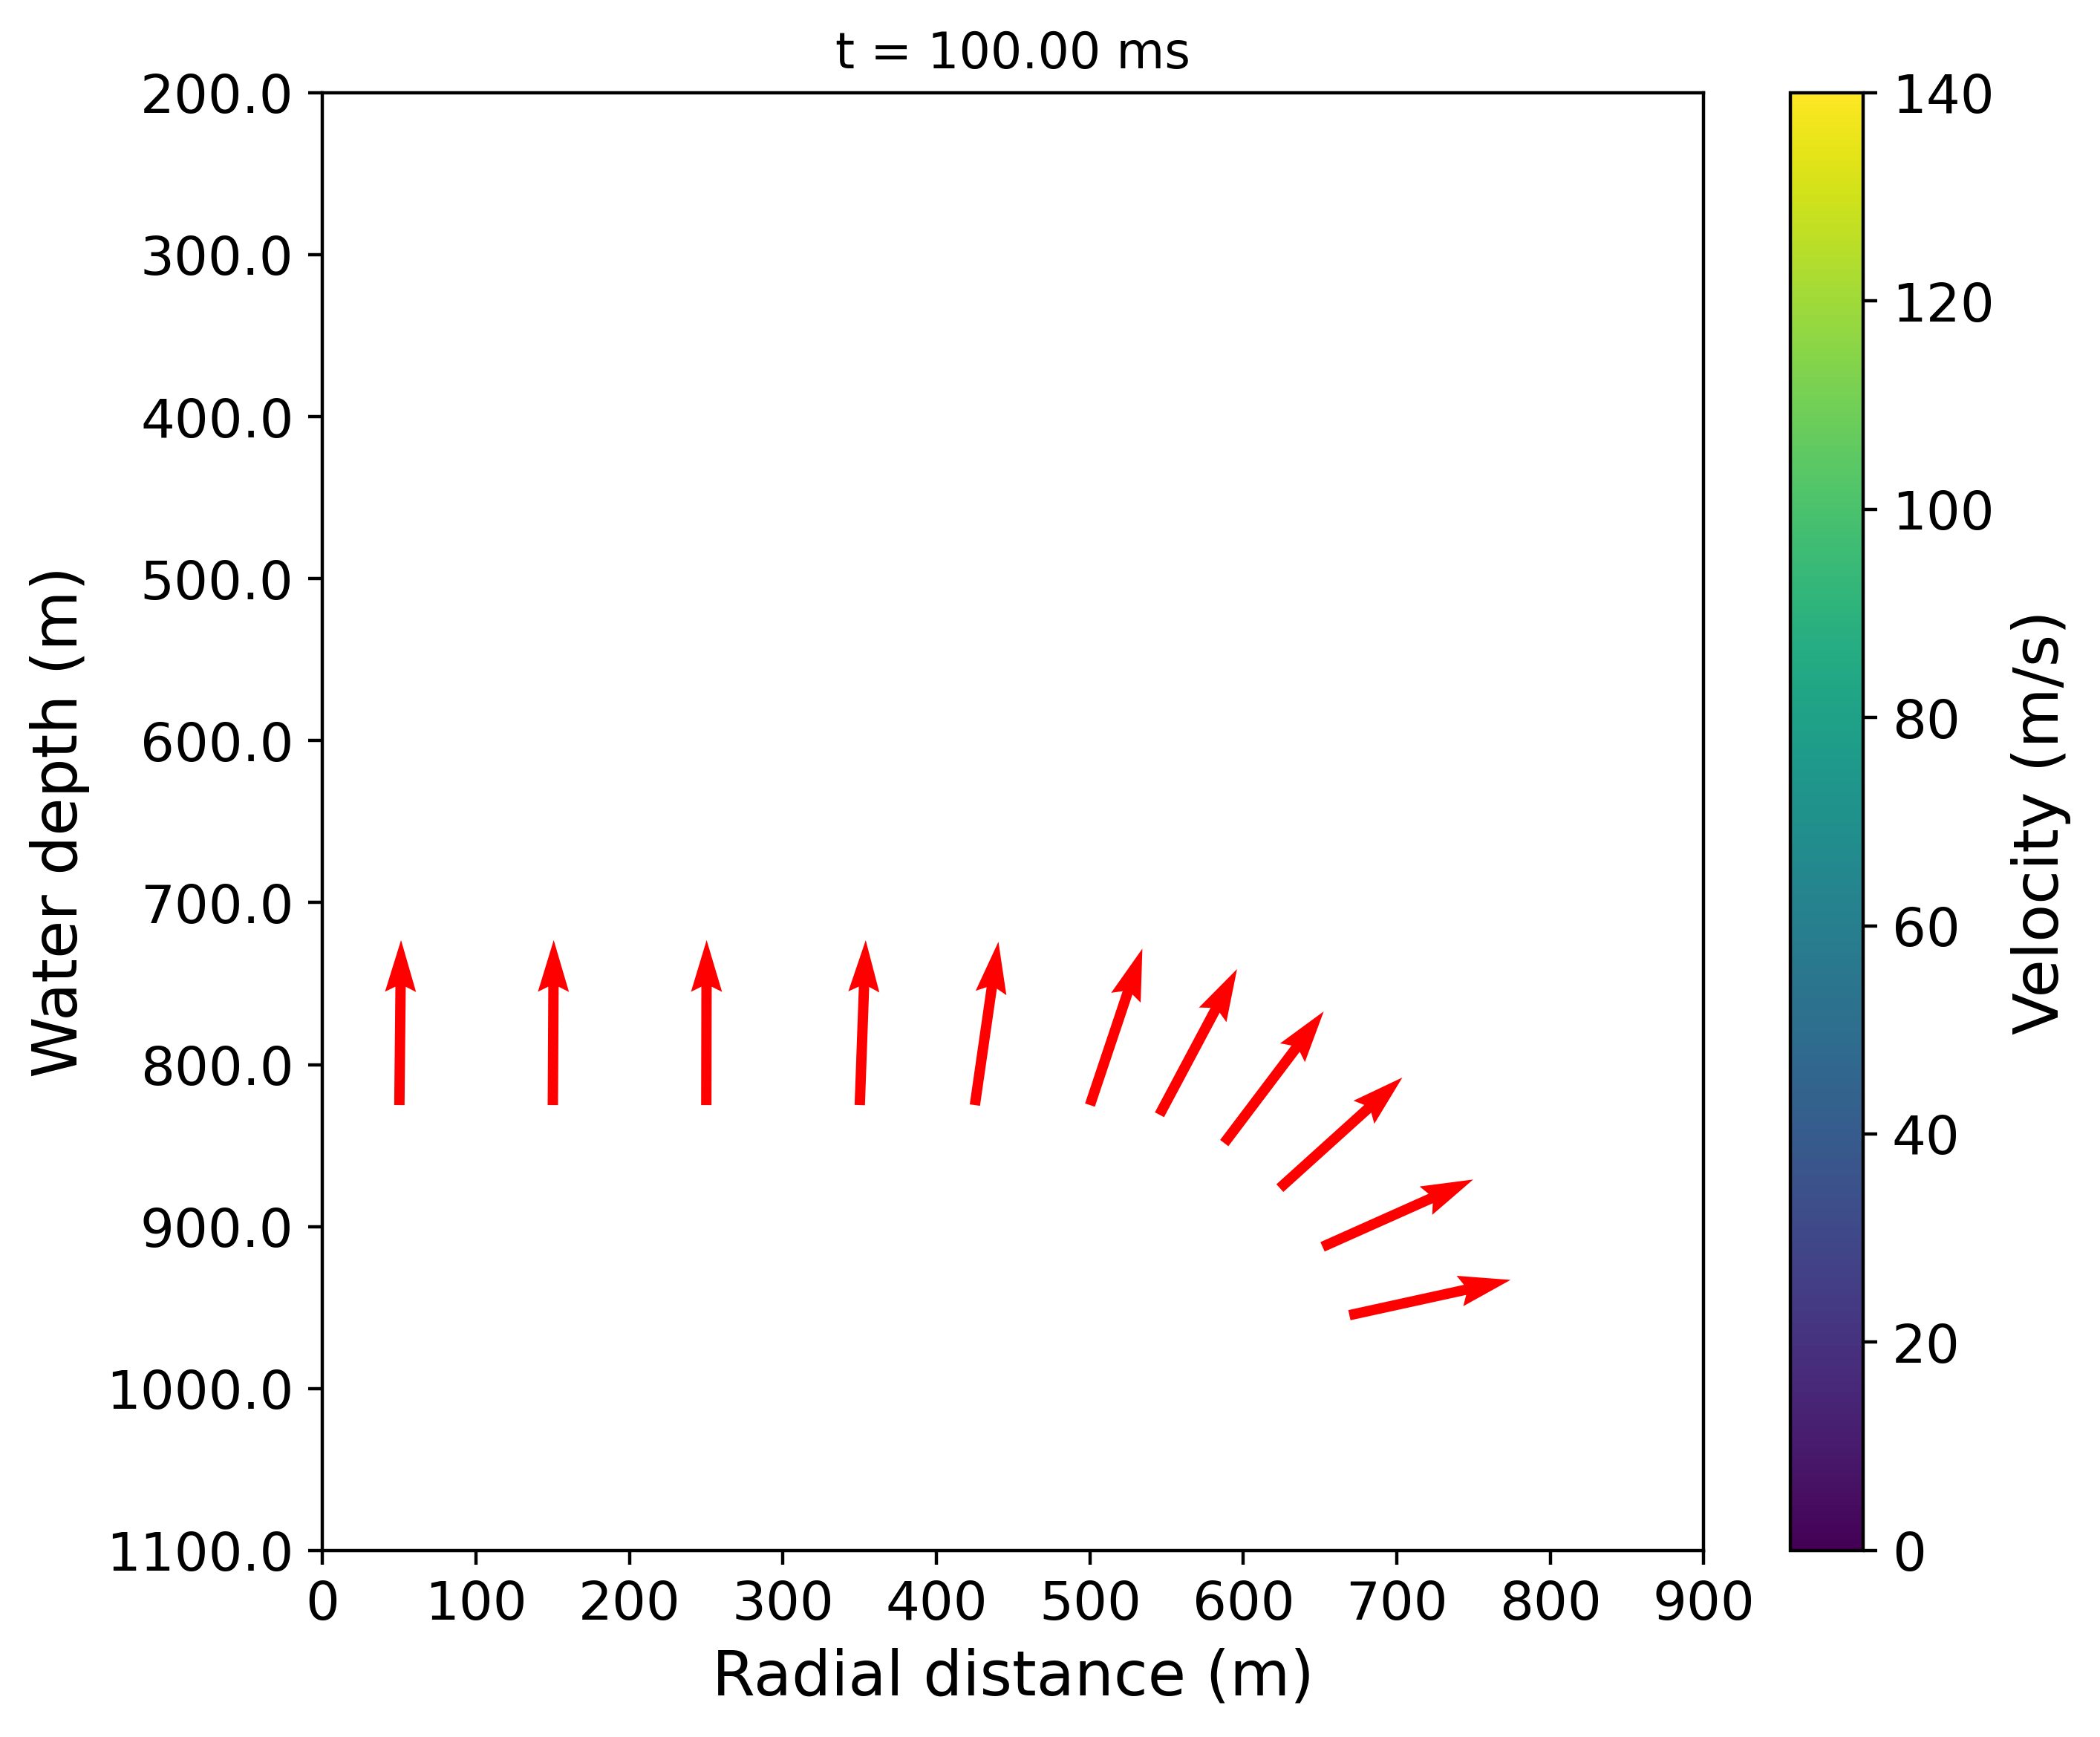

In [187]:
''' Generate quiver overlay '''
plt.figure(figsize=(7.5,6.5), dpi=400)
plt.clf()
soln_vars_i = process_file(50, [0], solver_from_multi)
clims = (0, 140)
velocity_norm = np.sqrt(soln_vars_i.u * soln_vars_i.u + soln_vars_i.v * soln_vars_i.v)
# mdtools.plot_mean(x, velocity_norm, clims)
# mdtools.plot_mean(x, soln_vars_i.T, clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
# tl = plt.title(f"Pressure delta (MPa) at t = {1e3*soln_vars_i.t:.2f} ms")
tl = plt.title(f"t = {1e3*soln_vars_i.t:.2f} ms")

# tl = plt.title(f"Pressure at t = {1e3*soln_vars_i.t:.2f} ms", fontsize=15)
# tl = plt.title(f"Temperature at t = {1e3*soln_vars_i.t:.2f} ms", fontsize=15)
# plt.xlim(0, 1000)
# plt.ylim(-350, 650)
plt.xlim(0,900)
plt.ylim(-100,800)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# cb.set_label(label='Temperature (K)', fontsize=15)
cb.set_label(label='Velocity (m/s)', fontsize=15)

plt.xlabel("Radial distance (m)", fontsize=15)
ax = plt.gca()
ax.yaxis.set_major_formatter(lambda x, _: f"{1000-x}")
plt.ylabel("Water depth (m)", fontsize=15)
cb.ax.tick_params(labelsize=13)

# Build circular arc
_theta_range = (np.pi / 2)* np.linspace(0, 1, 2*6+1)[-1:1:-2]
_arc_x, _arc_y = 500 + 175 * np.cos(_theta_range), 175 * np.sin(_theta_range)
# Indicate velocity direction
indicate_x = np.array([50,  150, 250, 350, 425, *_arc_x])
indicate_y = np.array([175, 175, 175, 175, 175, *_arc_y])
elem_indices = mdtools.SolverInterpolator(solver_from(0)).trifinder(indicate_x, indicate_y)
indicate_rhou = solver_from(50).state_coeffs[elem_indices, 0, 3:5]
indicate_n = indicate_rhou / np.linalg.norm(indicate_rhou, axis=-1, keepdims=True)
plt.quiver(indicate_x, indicate_y, indicate_n[...,0].ravel(), indicate_n[...,1].ravel(), 
           scale=1.8,
          scale_units="inches",
          #  units="dots",
          color="red",
           )

# plt.plot(ControlSurface(500,20).r, ControlSurface(500,20).y, '.-', color="#1f77b4")
# plt.plot(ControlSurface(750,20).r, ControlSurface(750,20).y, '.-', color="#ff7f0e")
# plt.plot(ControlSurface(1000,20).r, ControlSurface(1000,20).y, '.-', color="#2ca02c")

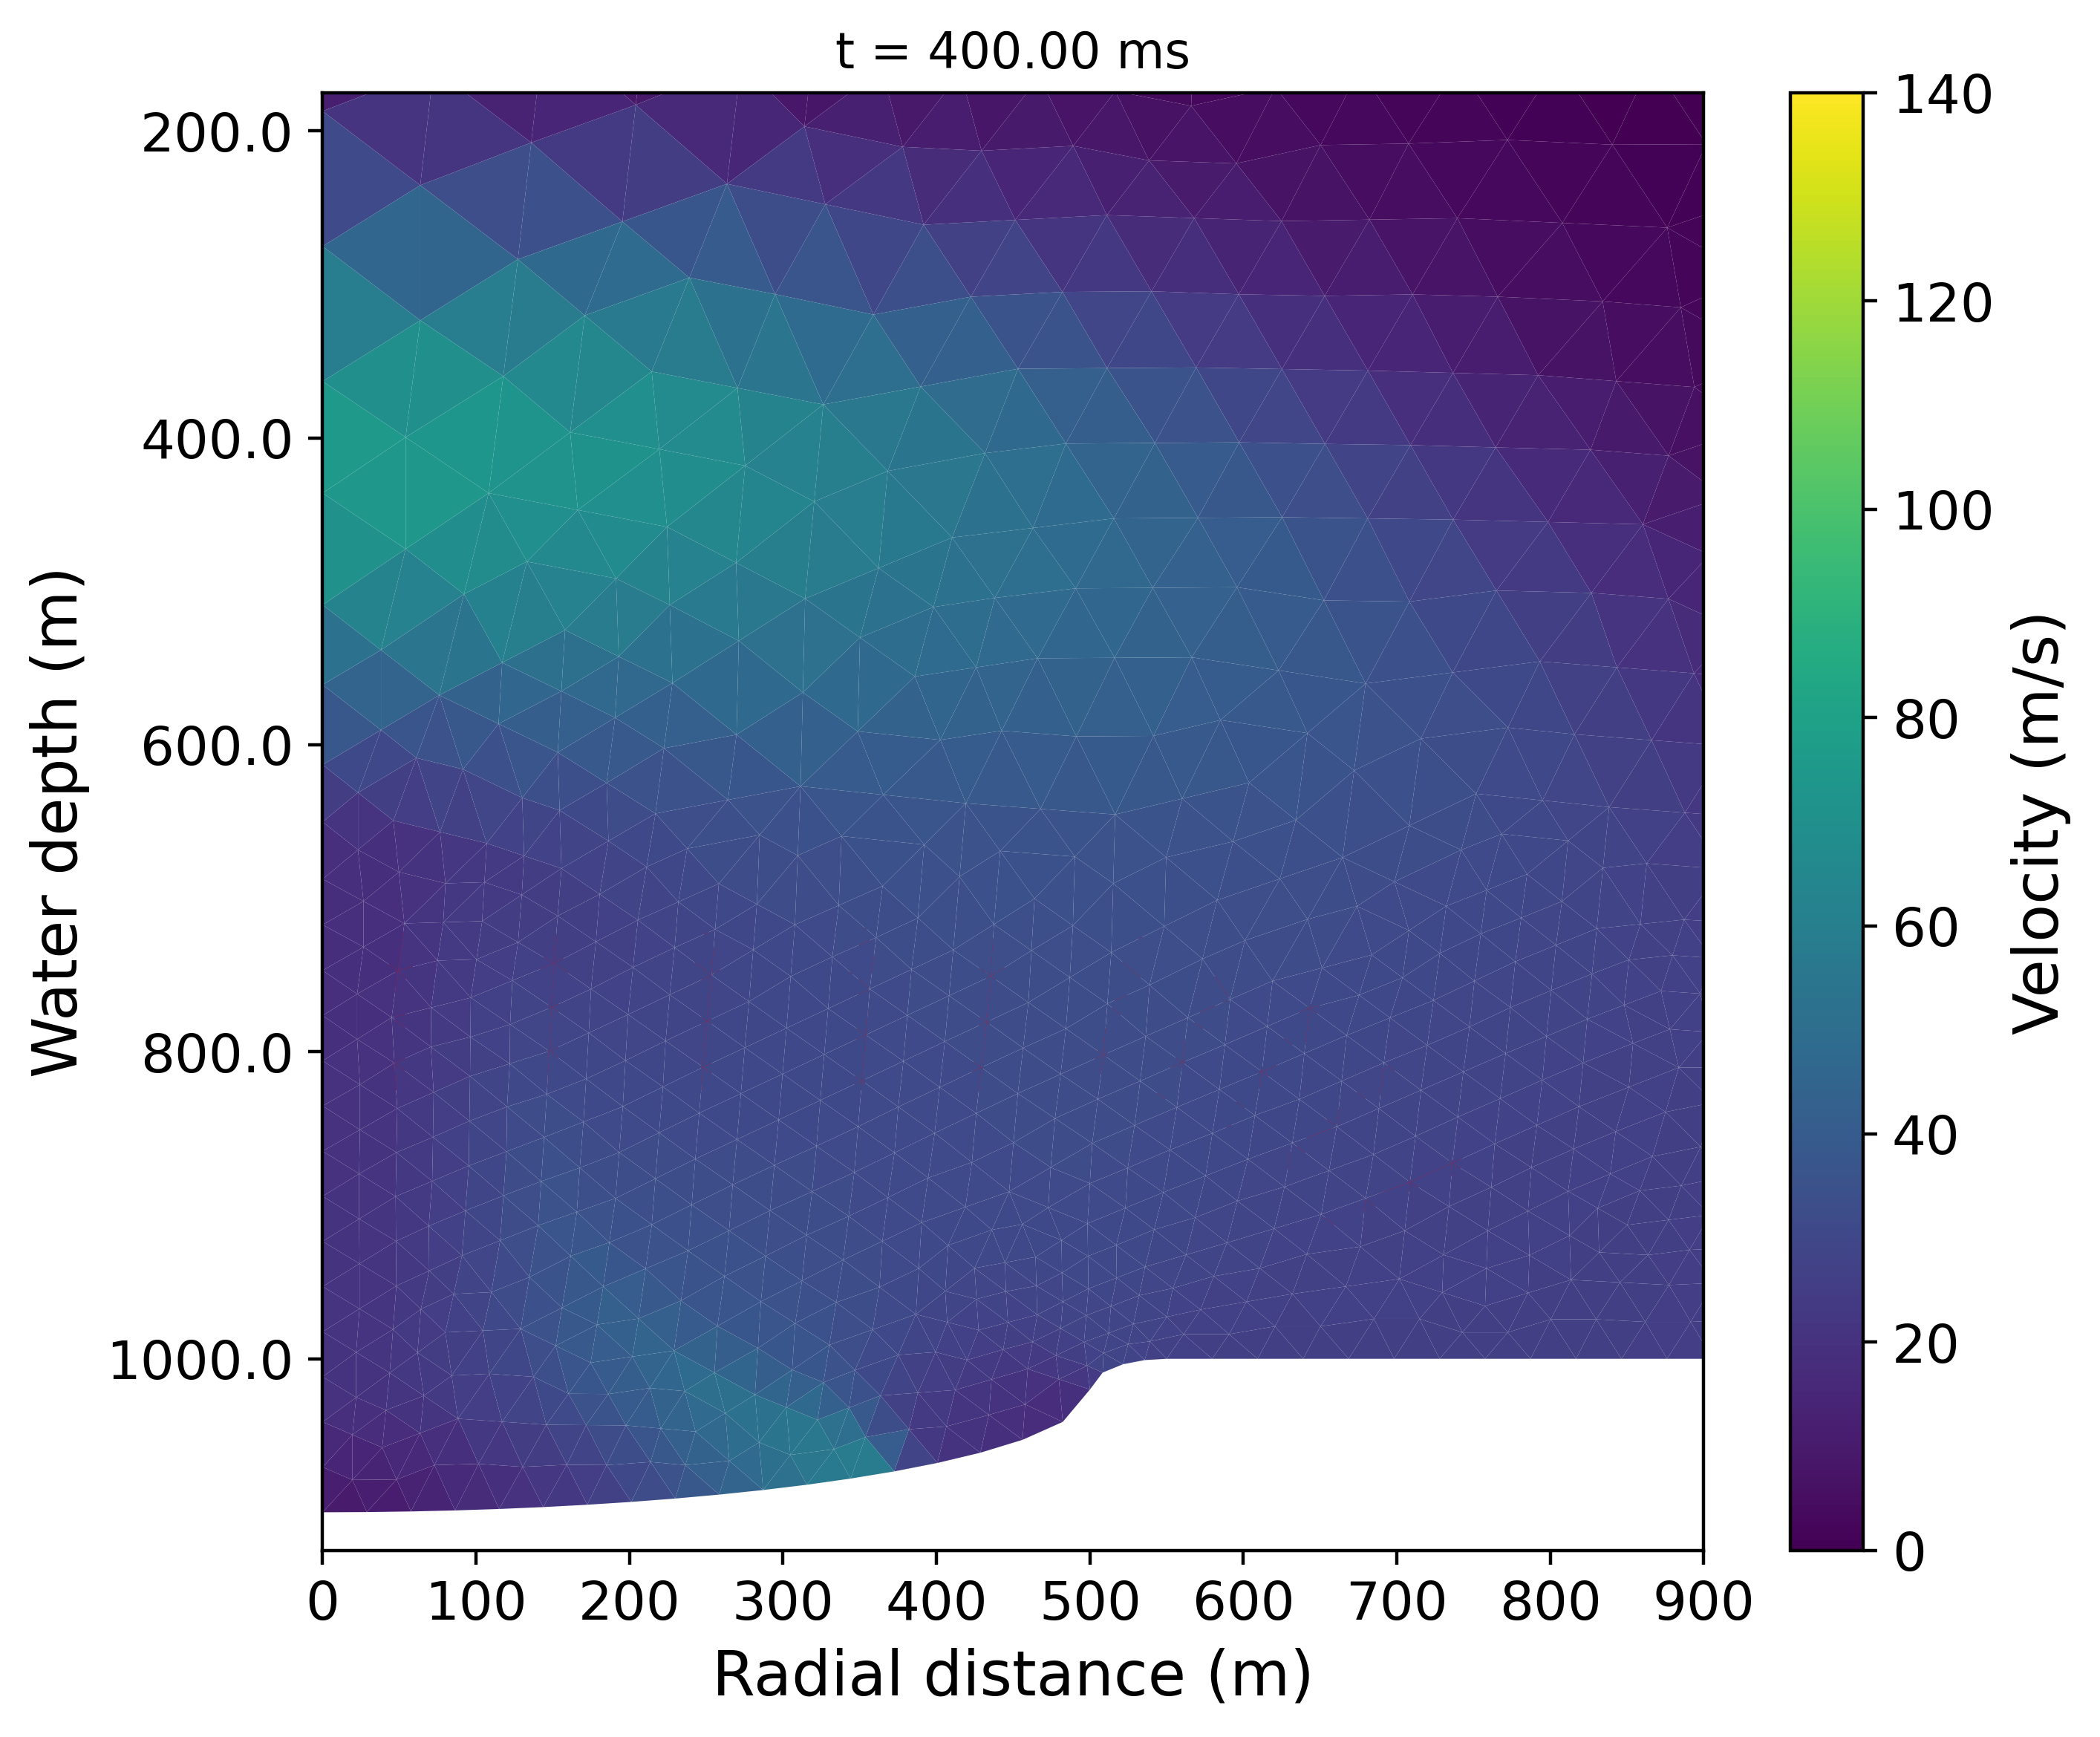

In [188]:
%matplotlib inline
''' Generate plots for display '''
plt.figure(figsize=(7.5,6.5), dpi=400)
plt.clf()
soln_vars_i = process_file(200, [0], solver_from_multi)
clims = (0, 140)
velocity_norm = np.sqrt(soln_vars_i.u * soln_vars_i.u + soln_vars_i.v * soln_vars_i.v)
mdtools.plot_mean(x, velocity_norm, clims)
# mdtools.plot_mean(x, soln_vars_i.T, clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
# tl = plt.title(f"Pressure delta (MPa) at t = {1e3*soln_vars_i.t:.2f} ms")
tl = plt.title(f"t = {1e3*soln_vars_i.t:.2f} ms")

# tl = plt.title(f"Pressure at t = {1e3*soln_vars_i.t:.2f} ms", fontsize=15)
# tl = plt.title(f"Temperature at t = {1e3*soln_vars_i.t:.2f} ms", fontsize=15)
# plt.xlim(0, 1000)
# plt.ylim(-350, 650)
plt.xlim(0,900)
plt.ylim(-100,800)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# cb.set_label(label='Temperature (K)', fontsize=15)
cb.set_label(label='Velocity (m/s)', fontsize=15)

plt.xlabel("Radial distance (m)", fontsize=15)
ax = plt.gca()
ax.yaxis.set_major_formatter(lambda x, _: f"{1000-x}")
plt.ylabel("Water depth (m)", fontsize=15)
cb.ax.tick_params(labelsize=13)

# Build circular arc
_theta_range = (np.pi / 2)* np.linspace(0, 1, 5+2)[-1:1:-1]
_arc_x, _arc_y = 500 + 175 * np.cos(_theta_range), 175 * np.sin(_theta_range)
# Indicate velocity direction
indicate_x = np.array([50,  150, 250, 350, 425, *_arc_x])
indicate_y = np.array([175, 175, 175, 175, 175, *_arc_y])
elem_indices = mdtools.SolverInterpolator(solver_from(0)).trifinder(indicate_x, indicate_y)
indicate_rhou = solver_from(50).state_coeffs[elem_indices, 0, 3:5]
indicate_n = indicate_rhou / np.linalg.norm(indicate_rhou, axis=-1, keepdims=True)
plt.quiver(indicate_x, indicate_y, indicate_n[...,0].ravel(), indicate_n[...,1].ravel(), 
           scale=1.8,
          scale_units="inches",
          #  units="dots",
          color="red",
           )

# plt.plot(ControlSurface(500,20).r, ControlSurface(500,20).y, '.-', color="#1f77b4")
# plt.plot(ControlSurface(750,20).r, ControlSurface(750,20).y, '.-', color="#ff7f0e")
# plt.plot(ControlSurface(1000,20).r, ControlSurface(1000,20).y, '.-', color="#2ca02c")

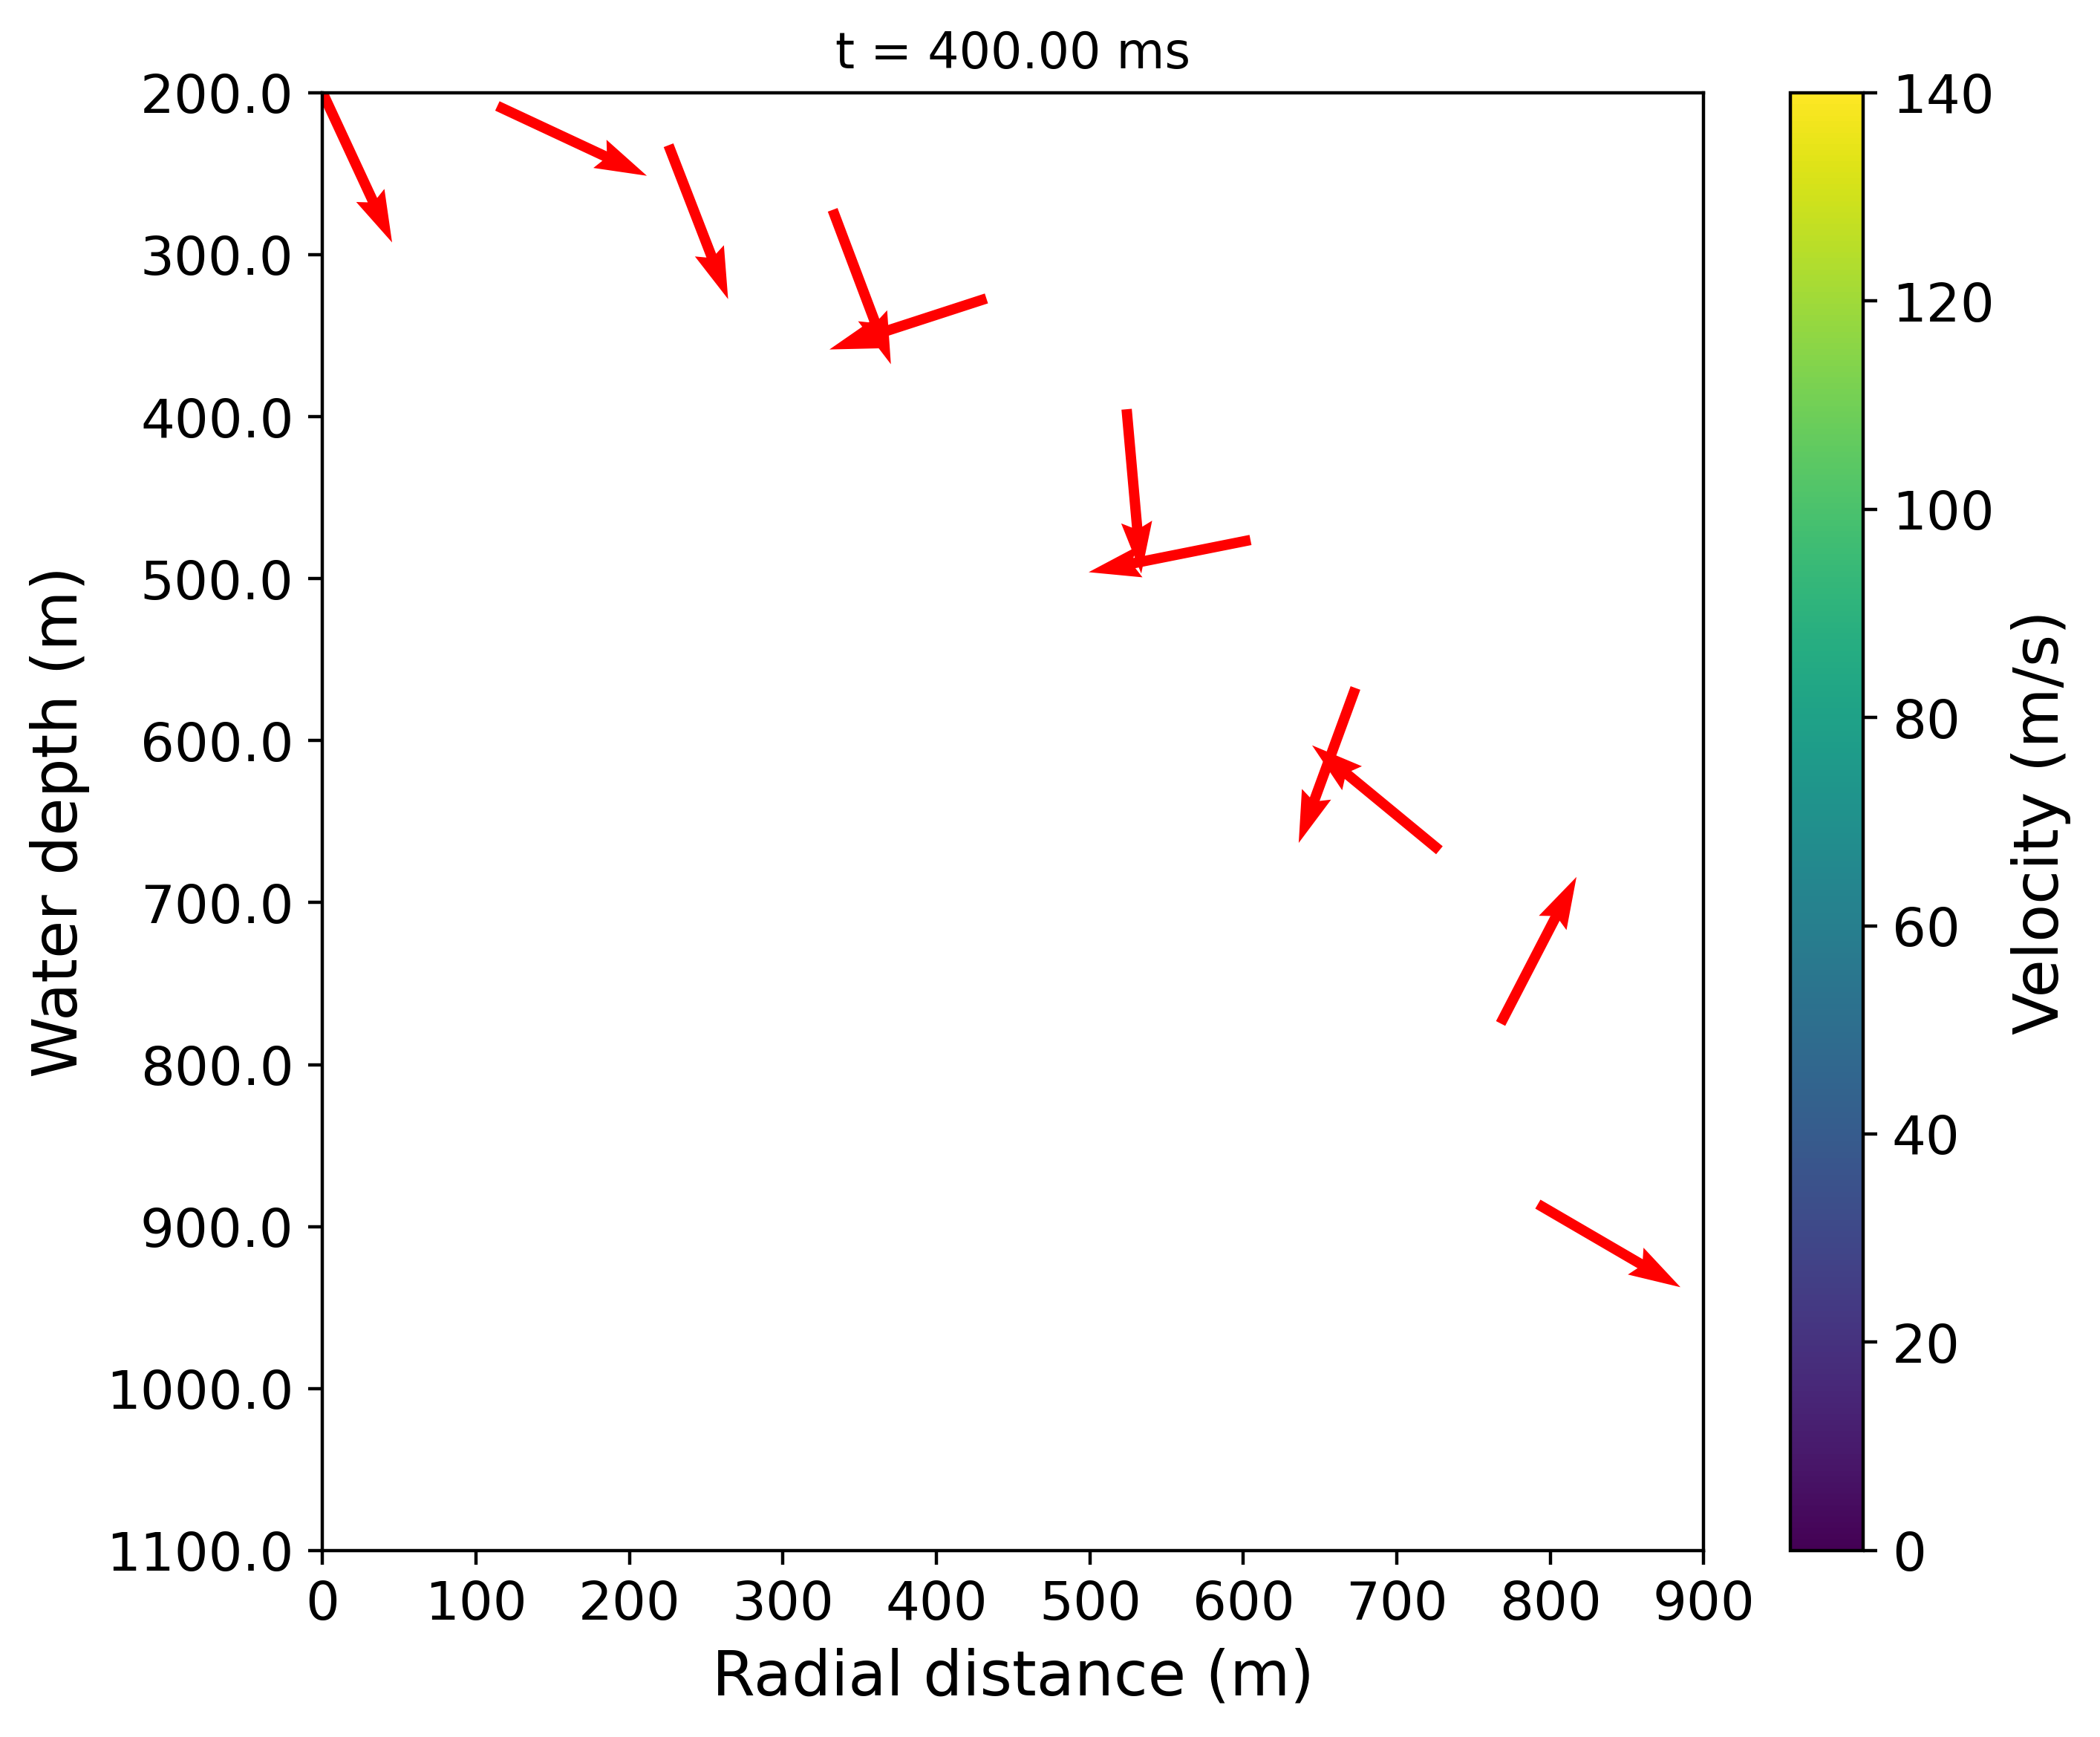

In [192]:
''' Generate quiver overlay '''
plt.figure(figsize=(7.5,6.5), dpi=400)
plt.clf()
# soln_vars_i = process_file(200, [0], solver_from_multi)
clims = (0, 140)
velocity_norm = np.sqrt(soln_vars_i.u * soln_vars_i.u + soln_vars_i.v * soln_vars_i.v)
# mdtools.plot_mean(x, velocity_norm, clims)
# mdtools.plot_mean(x, soln_vars_i.T, clims)
sm = plt.cm.ScalarMappable(
  norm=matplotlib.colors.Normalize(vmin=clims[0], vmax=clims[1]),
  cmap=plt.get_cmap())
cb = plt.colorbar(sm)
# tl = plt.title(f"Pressure delta (MPa) at t = {1e3*soln_vars_i.t:.2f} ms")
tl = plt.title(f"t = {1e3*soln_vars_i.t:.2f} ms")

# tl = plt.title(f"Pressure at t = {1e3*soln_vars_i.t:.2f} ms", fontsize=15)
# tl = plt.title(f"Temperature at t = {1e3*soln_vars_i.t:.2f} ms", fontsize=15)
# plt.xlim(0, 1000)
# plt.ylim(-350, 650)
plt.xlim(0,900)
plt.ylim(-100,800)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# cb.set_label(label='Temperature (K)', fontsize=15)
cb.set_label(label='Velocity (m/s)', fontsize=15)

plt.xlabel("Radial distance (m)", fontsize=15)
ax = plt.gca()
ax.yaxis.set_major_formatter(lambda x, _: f"{1000-x}")
plt.ylabel("Water depth (m)", fontsize=15)
cb.ax.tick_params(labelsize=13)

# Build circular arc
_theta_range = (np.pi / 2)* np.linspace(0, 1, 2*11+1)[-1:1:-2]
_arc_x, _arc_y = 800 * np.cos(_theta_range), 800 * np.sin(_theta_range)
# Indicate velocity direction
indicate_x = np.array([*_arc_x])
indicate_y = np.array([*_arc_y])
elem_indices = mdtools.SolverInterpolator(solver_from(0)).trifinder(indicate_x, indicate_y)
indicate_rhou = solver_from(50).state_coeffs[elem_indices, 0, 3:5]
indicate_n = indicate_rhou / np.linalg.norm(indicate_rhou, axis=-1, keepdims=True)
plt.quiver(indicate_x, indicate_y, indicate_n[...,0].ravel(), indicate_n[...,1].ravel(), 
           scale=1.8,
          scale_units="inches",
          #  units="dots",
          color="red",
           )

# plt.plot(ControlSurface(500,20).r, ControlSurface(500,20).y, '.-', color="#1f77b4")
# plt.plot(ControlSurface(750,20).r, ControlSurface(750,20).y, '.-', color="#ff7f0e")
# plt.plot(ControlSurface(1000,20).r, ControlSurface(1000,20).y, '.-', color="#2ca02c")

In [180]:
# Workspace
plt.clf()
plt.xlim(0,900)
plt.ylim(-100,800)
plt.quiver(indicate_x, indicate_y, indicate_n[...,0].ravel(), indicate_n[...,1].ravel(), 
           scale=1.8,
          scale_units="inches",
          #  units="dots",
           )


### Efficiency

In [48]:
file_name_i = lambda i: f"deep_submarine_crater5_atm1_{i}.pkl"                                 # 0.95
# file_name_i = lambda i: f"deep_submarine_crater10blast_atm1_{i}.pkl"   # 0.75
file_name_i = lambda i: f"H:\\submarine\\crater9\\deep_submarine_crater9blast_atm1_{i}.pkl"    # 0.50

solver_from = lambda i: readwritedatafiles.read_data_file(file_name_i(i))
solver_from_multi = lambda domidx, i: readwritedatafiles.read_data_file(file_name_i(i))

# soln_process = process_file(200, [0], solver_from_multi)

dt_file = solver_from(1).time - solver_from(0).time
physics = solver_from(0).physics

In [49]:
def xyt_interpolator_P0(x, y, t:np.array):
  ''' xyt interpolator implementation for element order 0.
  Input shapes:
    x: (n,)
    y: (n,)
    t: (m,)
  Output:
    U(x,y,t): (n,m,9)'''
  file_indices, thetas = divmod(t, dt_file)
  # Find relevant element indices
  elem_indices = mdtools.SolverInterpolator(solver_from(0)).trifinder(x, y)

  NUM_STATES = 9
  U_out = np.zeros((x.size,  t.size, NUM_STATES))

  for i, _ in enumerate(file_indices):
    # Find file indices
    theta = thetas[i]
    file_idx0 = int(file_indices[i])

    solver = solver_from(file_idx0)
    if solver.order > 0:
      raise ValueError("Element order is not 0, but using P0 interpolator")
    U0 = solver.state_coeffs[elem_indices, 0, :]

    if theta > 0:
      solver = solver_from(file_idx0+1)
    U1 =  solver.state_coeffs[elem_indices, 0, :]

    # Linearly interpolate state between file i and i+1
    U_out[:,i,:] = (1.0 - thetas[i]) * U0 + thetas[i] * U1
  return U_out

# xyt_interpolator_P0(control_surface.x, control_surface.y, np.array([0.2]))
xyt = xyt_interpolator_P0

In [132]:
def surface_integral(control_surface, t_array:np.array, dependent_fn:str):
  ''' Returns 3D surface integral of quant_name (e.g. Pressure) at time points
    as 1-D array t_array. '''
  # Pass dependent variable map composed with interpolator to control
  # surface functional
  return control_surface.integrate(
    lambda x, y: dependent_fn(xyt(x, y, t_array), x, y))

# Map from state coefficients to pressure
def U2p(U, x, y):
  return physics.compute_variable("Pressure", U)

def work_rate(U, x, y):
  ''' Return p * u (work per area-second)'''
  rho = U[...,0:3].sum(axis=-1, keepdims=True)
  r = np.sqrt(x*x + y*y)
  # Scalar component of normal velocity
  vel_normal = (np.einsum("ijk, i -> ijk", U[...,3:4], x/r)
                + np.einsum("ijk, i -> ijk ", U[...,4:5], y/r)) / rho
  return physics.compute_variable("Pressure", U) * vel_normal

def kinetic_flux(U, x, y):
  ''' Return 0.5 * rho * ||u||^2 * u_n (kinetic energy per area-second) '''
  rho = U[...,0:3].sum(axis=-1, keepdims=True)
  r = np.sqrt(x*x + y*y)
  # Scalar component of normal velocity
  vel_normal = (np.einsum("ijk, i -> ijk", U[...,3:4], x/r)
                + np.einsum("ijk, i -> ijk ", U[...,4:5], y/r)) / rho
  return 0.5 * (U[...,3:5]*U[...,3:5]).sum(axis=-1, keepdims=True) / rho * vel_normal

def mass_rate(U, x, y):
  ''' Return rho * vel_normal '''
  rho = U[...,0:3].sum(axis=-1, keepdims=True)
  r = np.sqrt(x*x + y*y)
  # Scalar component of normal velocity
  vel_normal = (np.einsum("ijk, i -> ijk", U[...,3:4], x/r)
                + np.einsum("ijk, i -> ijk ", U[...,4:5], y/r)) / rho
  return rho * vel_normal

def vol_rate(U, x, y):
  ''' Return vel_normal '''
  rho = U[...,0:3].sum(axis=-1, keepdims=True)
  r = np.sqrt(x*x + y*y)
  # Scalar component of normal velocity
  vel_normal = (np.einsum("ijk, i -> ijk", U[...,3:4], x/r)
                + np.einsum("ijk, i -> ijk ", U[...,4:5], y/r)) / rho
  return vel_normal

# Test integration
R = 500
integrated_p = surface_integral(ControlSurface(R, 20), np.array([0.70000]), U2p)
integrated_work = surface_integral(ControlSurface(R, 20), np.array([0.70000]), work_rate)
integrated_kinetic = surface_integral(ControlSurface(R, 20), np.array([0.70000]), kinetic_flux)
integrated_massrate = surface_integral(ControlSurface(R, 20), np.array([0.70000]), mass_rate)
integrated_volrate = surface_integral(ControlSurface(R, 20), np.array([0.70000]), vol_rate)

In [52]:
# Integrate work (p*u dA)
t_vector = np.linspace(0,2,121+1)
# Number of points to sample on control surface (sphere)
N_control_surface = 20
# Integrated work
integrated_work_history = surface_integral(ControlSurface(500, N_control_surface),
                                           t_vector,
                                           work_rate)

In [100]:
# Load and integrate

file_name_lambdas = [lambda i: f"deep_submarine_crater5_atm1_{i}.pkl",
                     lambda i: f"H:\\submarine\\crater10\\deep_submarine_crater10blast_atm1_{i}.pkl",
                     lambda i: f"H:\\submarine\\crater9\\deep_submarine_crater9blast_atm1_{i}.pkl"]

all_integ_work = []
for name in file_name_lambdas:
  solver_from = lambda i: readwritedatafiles.read_data_file(name(i))
  solver_from_multi = lambda domidx, i: readwritedatafiles.read_data_file(name(i))

  dt_file = solver_from(1).time - solver_from(0).time
  physics = solver_from(0).physics

  # Integrate work (p*u dA)
  t_vector = np.linspace(0,1.15,100+1)
  # Number of points to sample on control surface (sphere)
  N_control_surface = 20
  # Integrated work
  this_integrated_work_history = surface_integral(ControlSurface(500, N_control_surface),
                                            t_vector,
                                            work_rate)
  all_integ_work.append(this_integrated_work_history)

In [133]:
# Load and integrate mass rate

file_name_lambdas = [lambda i: f"deep_submarine_crater5_atm1_{i}.pkl",
                     lambda i: f"H:\\submarine\\crater10\\deep_submarine_crater10blast_atm1_{i}.pkl",
                     lambda i: f"H:\\submarine\\crater9\\deep_submarine_crater9blast_atm1_{i}.pkl"]

all_integ_mass_rate = []
all_integ_vol_rate = []
for name in file_name_lambdas:
  solver_from = lambda i: readwritedatafiles.read_data_file(name(i))
  solver_from_multi = lambda domidx, i: readwritedatafiles.read_data_file(name(i))

  dt_file = solver_from(1).time - solver_from(0).time
  physics = solver_from(0).physics

  # Integrate work (p*u dA)
  t_vector = np.linspace(0,1.15,100+1)
  # Number of points to sample on control surface (sphere)
  N_control_surface = 20
  # Integrated work
  this_integrated_mass_rate_history = surface_integral(ControlSurface(500, N_control_surface),
                                            t_vector,
                                            mass_rate)
  this_integrated_vol_rate_history = surface_integral(ControlSurface(500, N_control_surface),
                                            t_vector,
                                            vol_rate)
  all_integ_mass_rate.append(this_integrated_mass_rate_history)
  all_integ_vol_rate.append(this_integrated_vol_rate_history)

In [101]:
# Compute Q (heat transfer)
masses = []
mix_temperatures = []
for name in file_name_lambdas:
  djac_elems = solver_from(0).elem_helpers.djac_elems
  elem_vols = djac_elems[:,0,0]
  # Hemispherical rotation of area pi * r * dA
  x_centroids = solver_from(0).mesh.node_coords[solver_from(0).mesh.elem_to_node_IDs].mean(axis=1)
  # Estimate from integration 
  mass_m = (np.pi * x_centroids[:,0] * elem_vols * solver_from(0).state_coeffs[:,0,2]).sum(axis=0)
  masses.append(mass_m)
  T = solver_from(0).physics.compute_variable("Temperature", solver_from(0).state_coeffs).max()
  mix_temperatures.append(T)
  # x_centroids[:,0].shape, solver_from(0).state_coeffs[...,2].shape

masses = np.array(masses)
mix_temperatures = np.array(mix_temperatures)

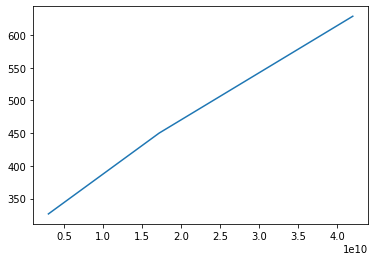

In [102]:
plt.plot(masses, mix_temperatures)

In [103]:
T_m0 = 1000
c_m = solver_from(0).physics.Liquid["c_m"] 

# Heat per mass
q = c_m * (T_m0 - mix_temperatures)
Q = q * masses

In [87]:
Q

array([6.072278560683736e+15, 2.834006008063005e+16,
       4.672647936585956e+16])

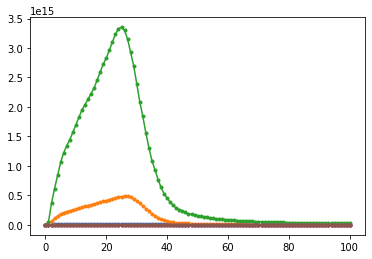

In [104]:
work_rates = np.array(all_integ_work).squeeze()

work_rates.shape
plt.plot(work_rates.T, '.-')

plt.plot(work_rates.T / Q, '.-')


In [105]:
cdf_work = (t_vector[1] - t_vector[0]) * scipy.integrate.cumulative_trapezoid(work_rates, axis=1)

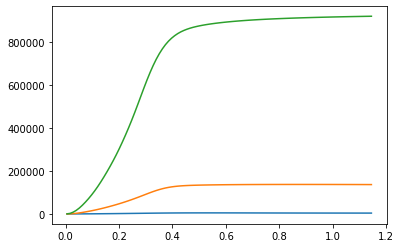

In [106]:
# Work accumulate
plt.plot(0.5 * (t_vector[:-1] + t_vector[1:]),
         (t_vector[1] - t_vector[0]) * scipy.integrate.cumulative_trapezoid(work_rates, axis=1).T / 1e9)

In [108]:
Q

array([6.072278560683736e+15, 2.834006008063005e+16,
       4.672647936585956e+16])

In [110]:
work_rates.shape

(3, 101)

In [115]:
work_cumulative = (t_vector[1] - t_vector[0]) * scipy.integrate.cumulative_trapezoid(work_rates, axis=1).T
work_cumulative.shape, Q.shape

((100, 3), (3,))

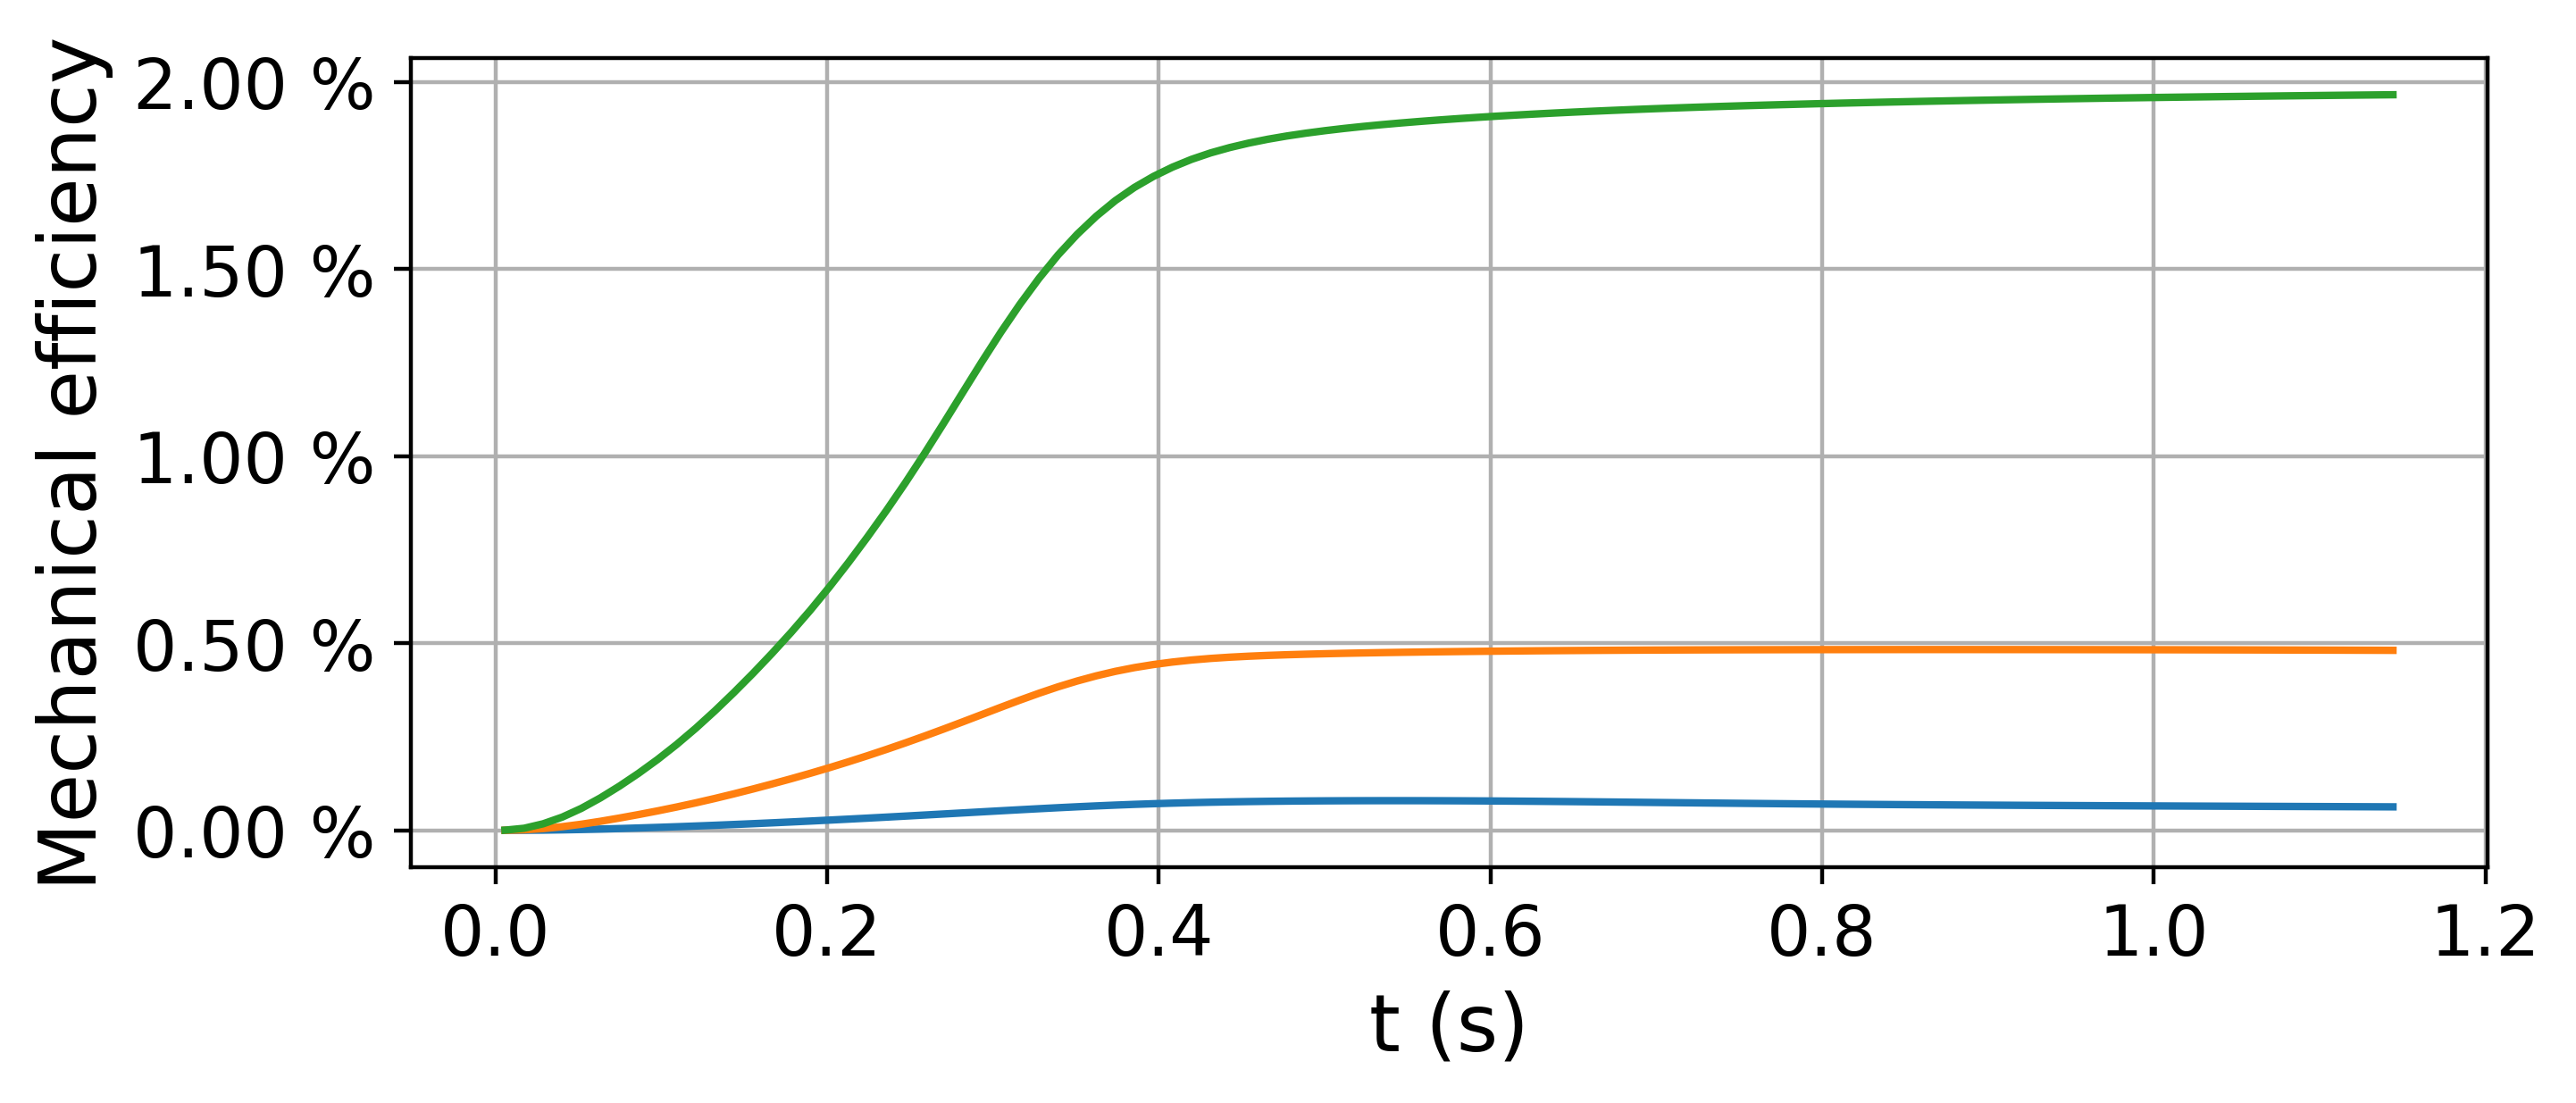

In [195]:
# Efficiency accumulate

t_mean = 0.5 * (t_vector[:-1] + t_vector[1:])
plt.figure(figsize=(7.5,3), dpi=400)

plt.plot(t_mean, work_cumulative / Q)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("t (s)", fontsize=16)
ax = plt.gca()
ax.yaxis.set_major_formatter(lambda x, _: f"{100*x:.2f} %")
plt.ylabel("Mechanical efficiency", fontsize=16)
plt.grid("both")

In [134]:
mass_rates = np.array(all_integ_mass_rate).T.squeeze()
vol_rates = np.array(all_integ_vol_rate).T.squeeze()

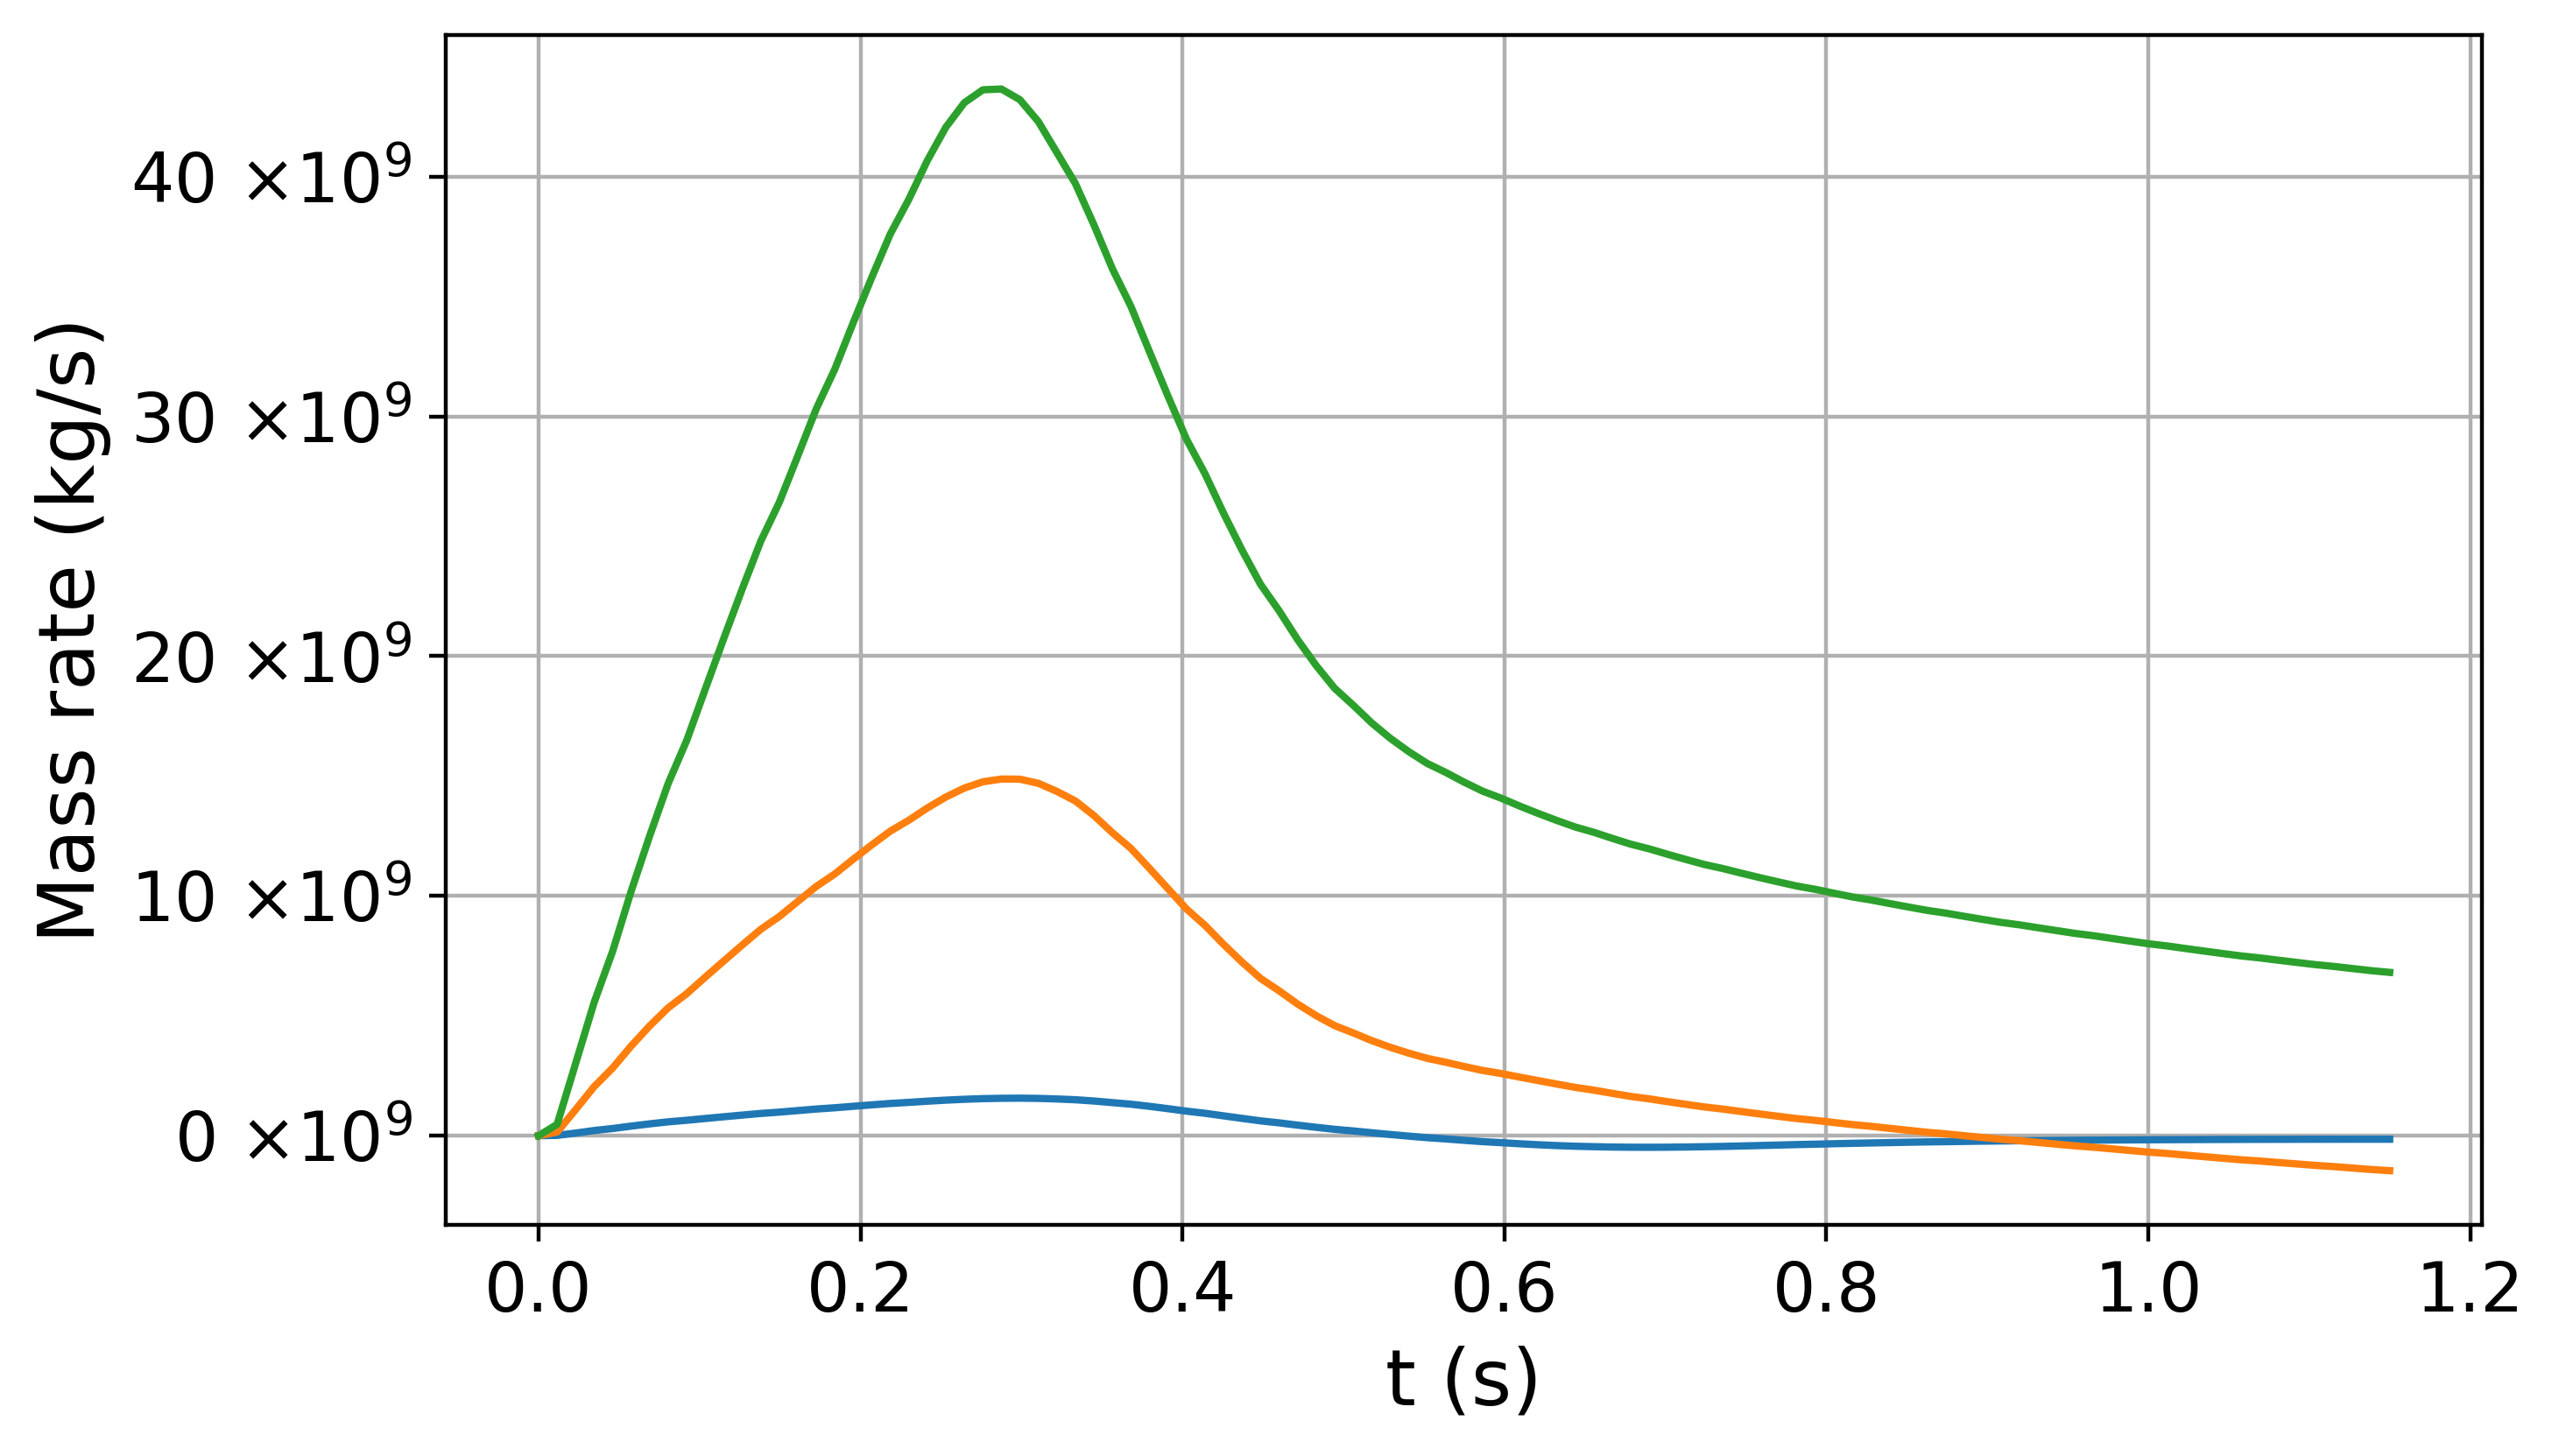

In [137]:
# Efficiency accumulate

# t_mean = 0.5 * (t_vector[:-1] + t_vector[1:])
plt.figure(figsize=(7.5,4.5), dpi=400)

plt.plot(t_vector, mass_rates)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("t (s)", fontsize=16)
ax = plt.gca()
ax.yaxis.set_major_formatter(lambda x, _: f"{x/1e9:.0f} $\\times 10^{9}$")
plt.ylabel("Mass rate (kg/s)", fontsize=16)
plt.grid("both")

In [146]:
t_mean = 0.5 * (t_vector[:-1] + t_vector[1:])
volume_cumulative = (t_vector[1] - t_vector[0]) * scipy.integrate.cumulative_trapezoid(vol_rates, axis=0)
volume_cumulative.shape

(100, 3)

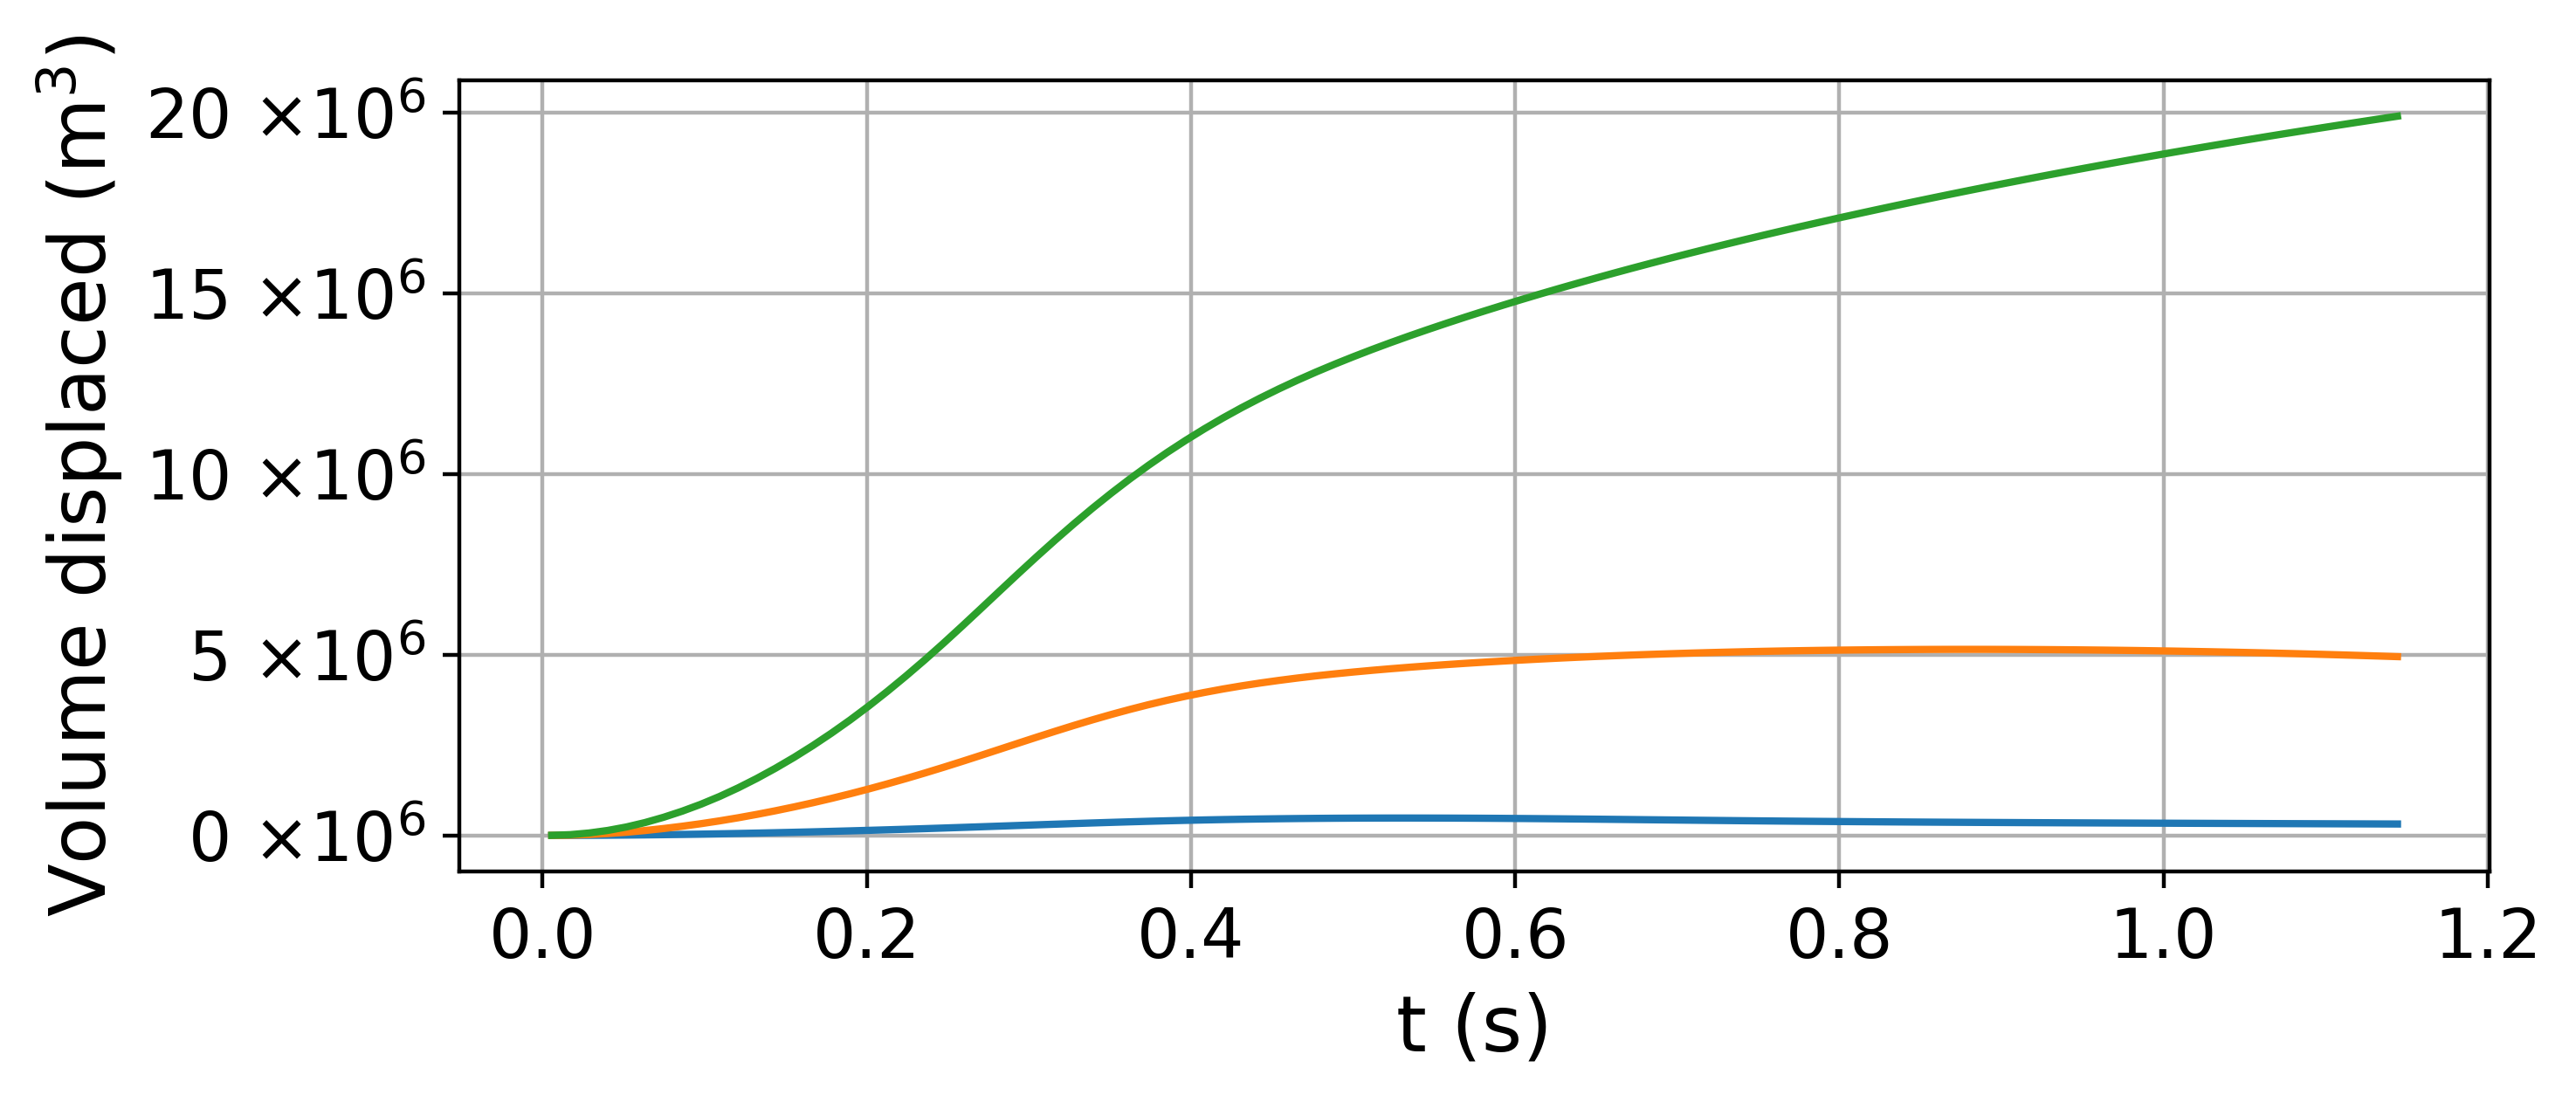

In [194]:
# Efficiency accumulate

# t_mean = 0.5 * (t_vector[:-1] + t_vector[1:])
plt.figure(figsize=(7.5,3), dpi=400)

# plt.plot(t_vector, vol_rates)
plt.plot(t_mean, volume_cumulative)
# volume_cumulative
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("t (s)", fontsize=16)
ax = plt.gca()
ax.yaxis.set_major_formatter(lambda x, _: f"{x/1e6:.0f} $\\times 10^{6}$")
plt.ylabel("Volume displaced (m${}^3$)", fontsize=16)
plt.grid("both")

## Riemann invariant integration

The simple wave construction follows the acoustic eigenvector, giving the
incremental momentum constraint
```
rho du = c drho
```
and from the energy constraint
```
de = - p dv.
```
The latter is identified with thermodynamics as the isentropic constraint
```
ds = 0
```
which implies isentropic compression
```
dp = c^2 drho.
```
Using this isentropic relation, the momentum constraint can be equivalently written
```
rho c du = dp
```

For a Helmholtz-based description of water, the variables (T, v) or (T, rho)
are natural and typically do not require iterative solves. However, we wish to
use p as an independent variable for the right start and end points for the
integration. Thus, we need a coordinate transform between (T, rho) and (p, s)
```
(dp) = (p_T p_v) (dT)
(ds)   (s_T s_v) (dv)
```
with subscripts indicating partial derivative with respect to T or v.

The constraint ds = 0 implies that we can parametrize by independent variable p.
Dividing by dp and inverting the matrix above,
```
(dT/dp) = (s_v )  / det
(dv/dp)   (-s_T)  / det
```
where det is the determinant `det = p_T * s_v - p_v * s_T`. Finally, the system
we solve is the ODE on a fixed interval (p0, p_target)

```
du/dp = 1 / (rho * c)
dT/dp = s_v / (p_T * s_v - p_v * s_T)
dv/dp = -s_T / (p_T * s_v - p_v * s_T)
```
det = p_T * s_v - p_v * s_T

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Config
import copy
import os
import numpy as np
from numpy.linalg import norm
import matplotlib
import matplotlib.pyplot as plt

# Path for ffmpeg (if animations are needed)
plt.rcParams['animation.ffmpeg_path'] = "C:\\Users\\Fredric\\Documents\\ffmpeg\\ffmpeg-n4.4-latest-win64-gpl-4.4\\bin\\ffmpeg.exe"

# Path for .pkl files output
# target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\tungurahua\\"
target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\submarine\\"
# target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\results_dx4m\\"

# Path for Quail source code
source_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\src\\"

# Path for Quail entry point
quail_path = os.path.join(source_dir, "quail")

In [ ]:
# Import quail modules
os.chdir(source_dir)
import argparse
import importlib
import sys
import scipy

import defaultparams as default_deck
import errors
from general import ShapeType, SolverType, PhysicsType

import meshing.common as mesh_common
import meshing.gmsh as mesh_gmsh
import meshing.tools as mesh_tools

import numerics.helpers.helpers as helpers
import numerics.timestepping.tools as stepper_tools

import physics.zerodimensional.zerodimensional as zerod
import physics.euler.euler as euler
import physics.navierstokes.navierstokes as navierstokes
import physics.scalar.scalar as scalar
import physics.chemistry.chemistry as chemistry
import physics.multiphasevpT.multiphasevpT as multiphasevpT
import physics.multiphaseWLMA.multiphaseWLMA as multiphaseWLMA
import physics.multiphaseWLMA.iapws95_light.mixtureWLMA as mixtureWLMA

import processing.readwritedatafiles as readwritedatafiles
import processing.post as post
import processing.plot as plot
import processing
import processing.mdtools as mdtools

import solver.DG as DG
import solver.ADERDG as ADERDG
import solver.tools as solver_tools

import time
import multiprocessing as mp
from multidomain import Domain, Observer

from types import SimpleNamespace

os.chdir(target_dir)

In [ ]:
mixtureWLMA

<module 'physics.multiphaseWLMA.iapws95_light.mixtureWLMA' from 'C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\src\\physics\\multiphaseWLMA\\iapws95_light\\mixtureWLMA.py'>

In [ ]:
rho = 996.9
T = 300

R, rhoc, Tc = mixtureWLMA.R, mixtureWLMA.rhoc, mixtureWLMA.Tc
# Compute d(p, s) / d(T, rho)
d = rho / rhoc
t = Tc / T
_phi0 = mixtureWLMA.float_phi_functions.fused_phi0_all(d, t)
_phir = mixtureWLMA.float_phi_functions.fused_phir_all(d, t)